(overview_plots)=
# Overview

ArviZ-plots is the plotting library of ArviZ. It comes with "batteries-included" plots, which means it includes a set of predefined plotting functions that cover a wide range of common use cases in Bayesian data analysis, like MCMC diagnostics, predictive checks, model comparison, and more. These functions are designed to be easy to use, with sensible defaults that allow users to quickly generate high-quality plots without needing to customize every aspect of the visualization. You can take a look at the {ref}`gallery <example_gallery>` to see some examples of the available plots. And you can refer to the {ref}`API reference <plots_api>` for a more detailed description of the available plotting functions.

## Getting Started with ArviZ-plots

To start, we’ll import ArviZ. We'll also apply a default style for the plots, this is optional, but it will make the plots look nicer and include nice features like colorblind-friendly palettes.

In [1]:
import arviz_base as azb
import arviz_plots as azp
azp.style.use("arviz-variat")

To make the example easier to follow we are going to skip the modeling step, and assume we have already built and solve a Bayesian model. ArviZ provides several pre-saved models, so we can use one of those to demonstrate the plotting functionality. In this case we will use the `centered_eight` model, which is a classic, but even if you are not familiar with it, you can still follow along and see how the plotting functions work.

In [2]:
data = azb.load_arviz_data("centered_eight")

A common task in Bayesian data analysis is to compute the posterior and then inspect it visually. For instance, we can use the `plot_dist` function to visualize the posterior distribution of a model. By default this function produces a plot that shows the distribution of the posterior samples for each parameter in the model.

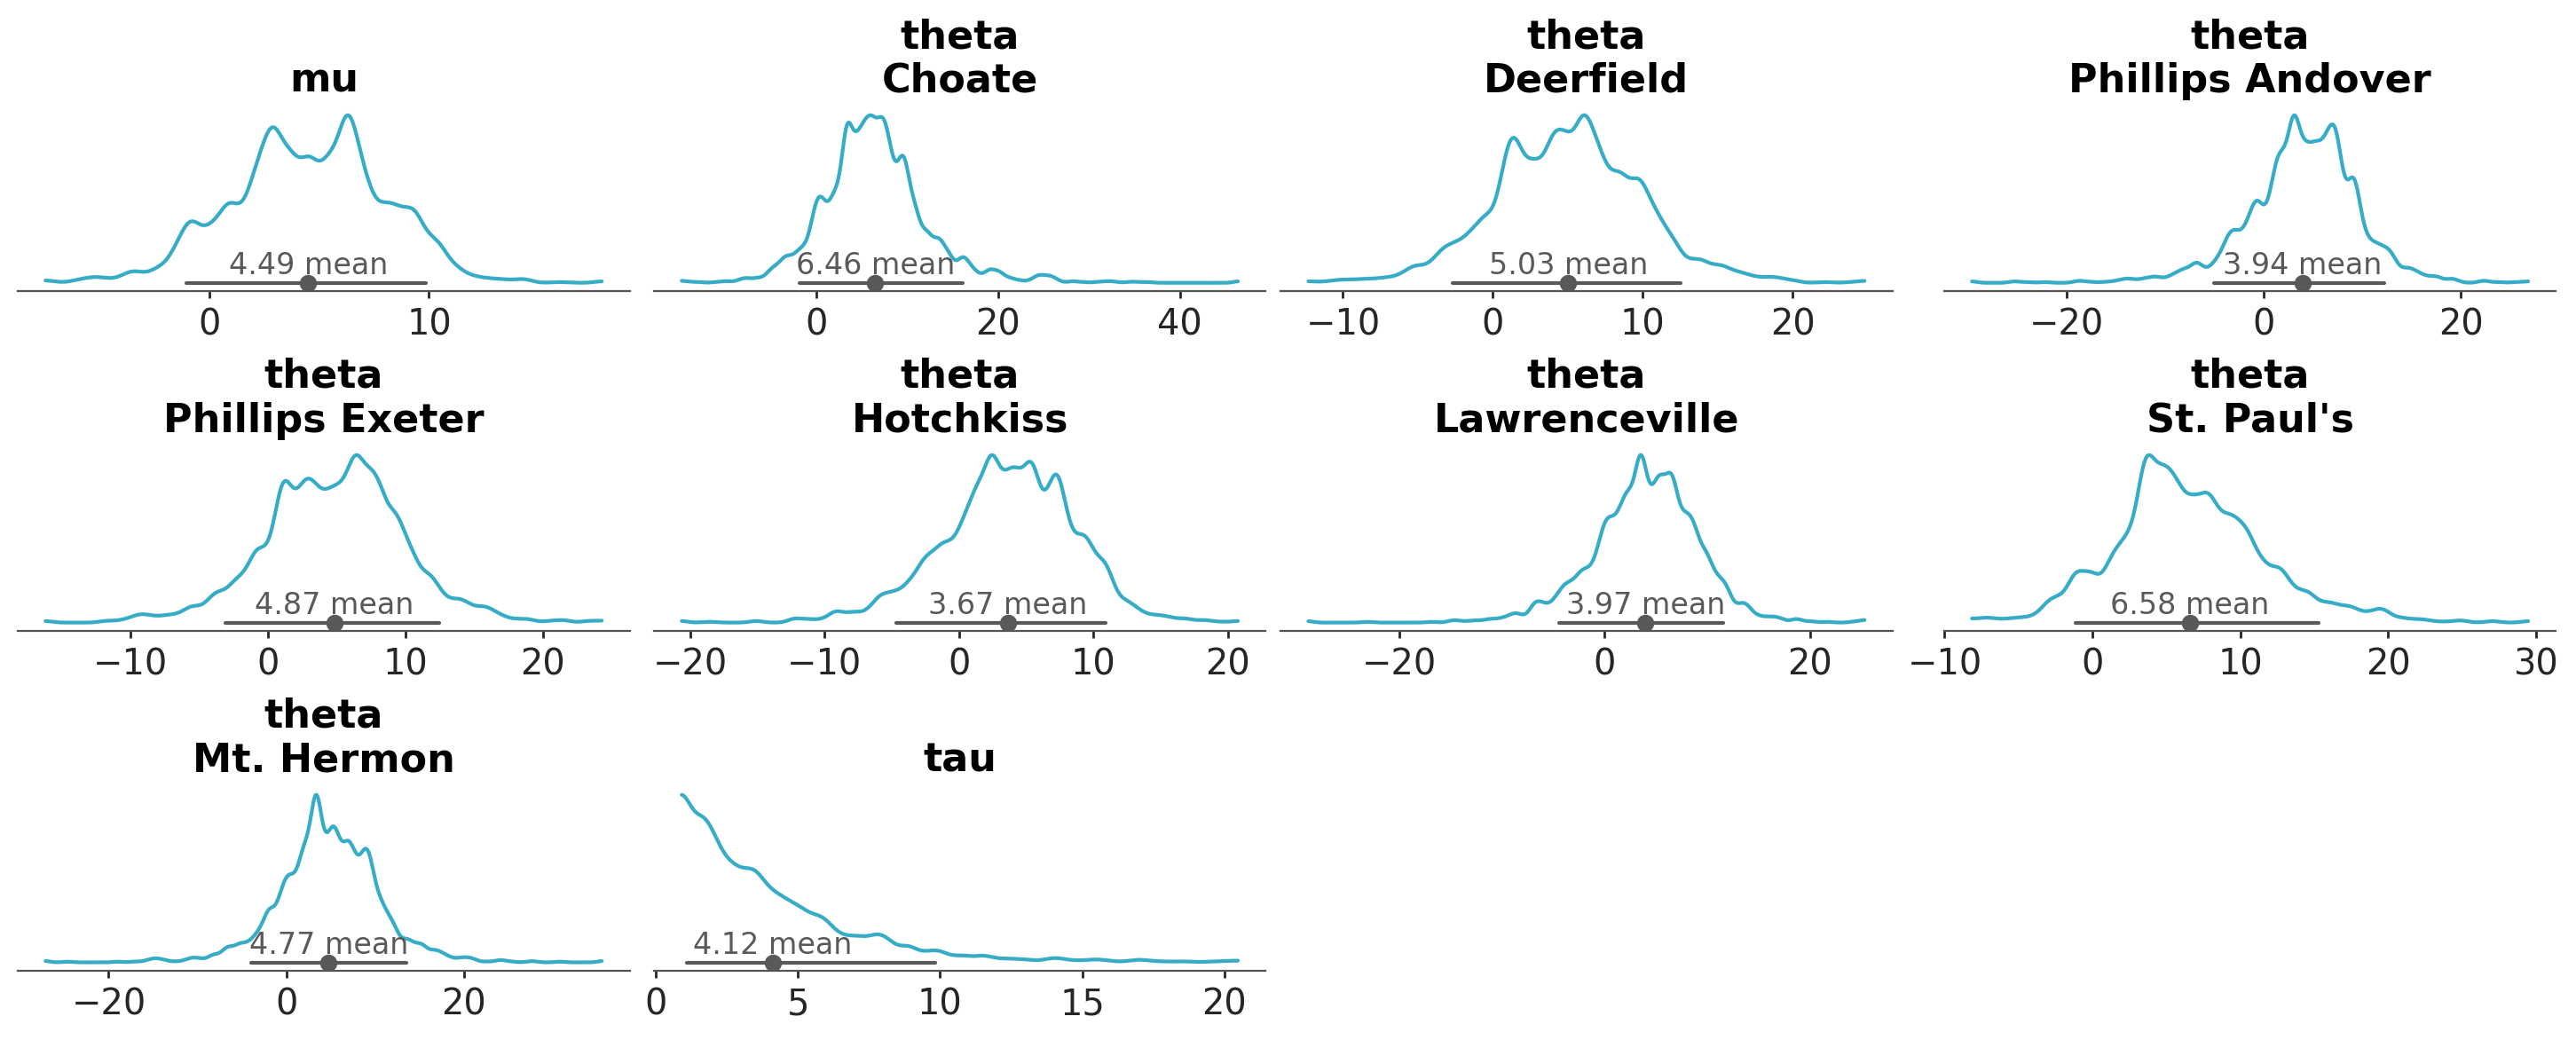

In [3]:
azp.plot_dist(data);

As we can see, each marginal of the posterior distribution is represented using a [kernel density estimate (KDE)](https://arviz-devs.github.io/EABM/Chapters/Distributions.html#kde). In this example, there are 3 variables (or parameters), `mu`, `tau` and `theta`, the first two are unidimesional, while `theta` is a vector of length 8. Thus, in total we got 10 plots. In addition to the KDE, the plot includes a point interval that shows the mean and the 94% equal-tailed credible interval.

If we want to focus on a specific variable or a subset of variables, we can use the `var_names` argument to specify which ones to display. We simply pass the names of the variables we'd like to plot.

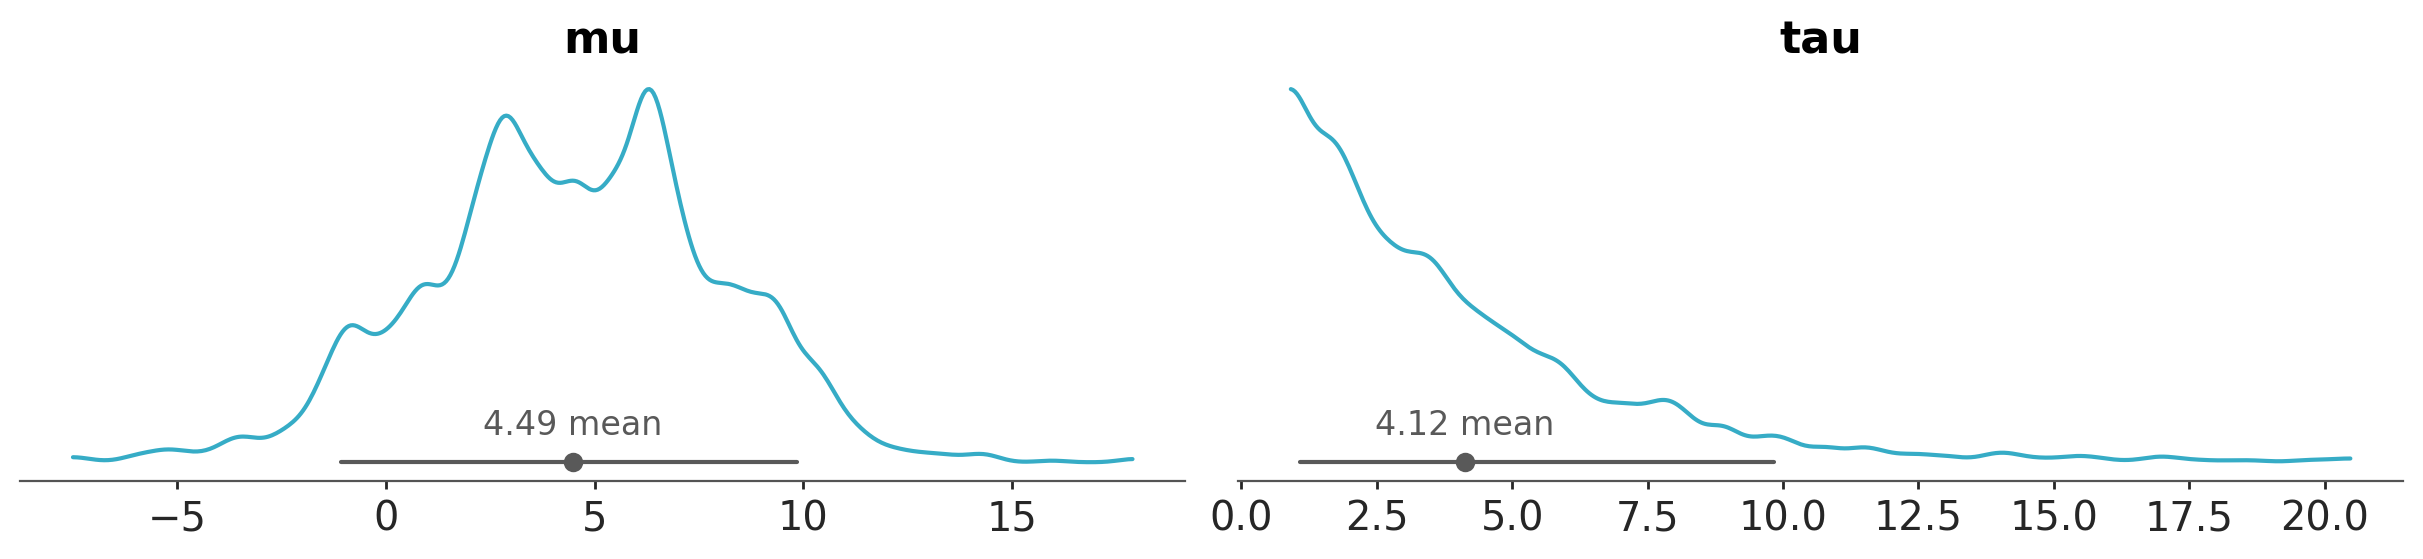

In [4]:
azp.plot_dist(data, var_names=["mu", "tau"]);

or negate the ones we don't want to plot.


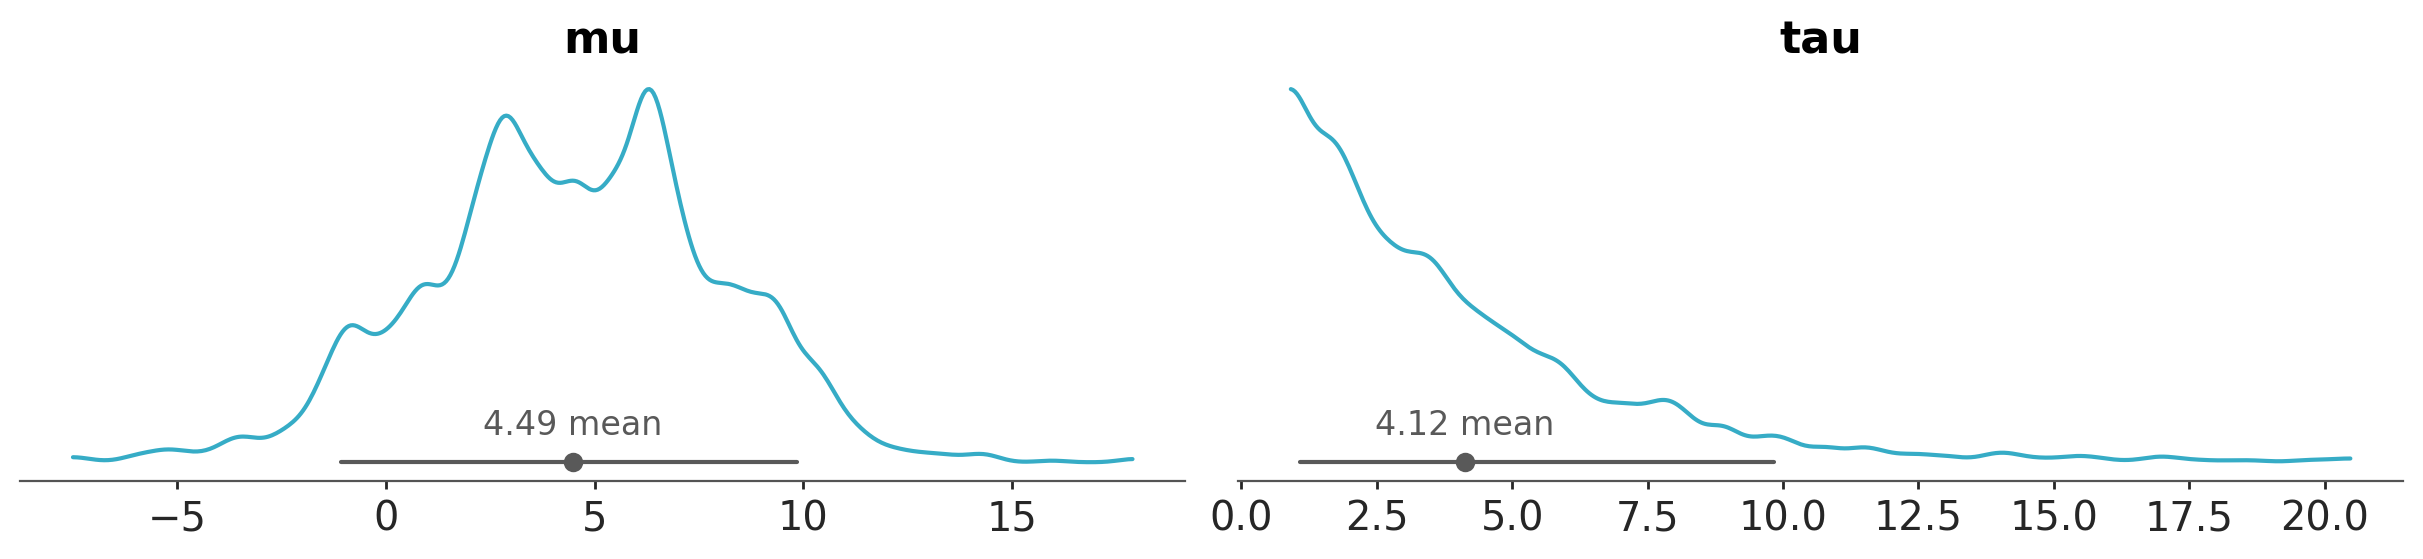

In [5]:
azp.plot_dist(data, var_names=["~theta"]);

Let's say that we want to visualize the posterior distribution and the prior distribution together. We can use the `plot_prior_posterior` function. Because the prior is much wider than the posterior (except for `mu`), we see that the prior looks almost flat and the posterior is a spike. 

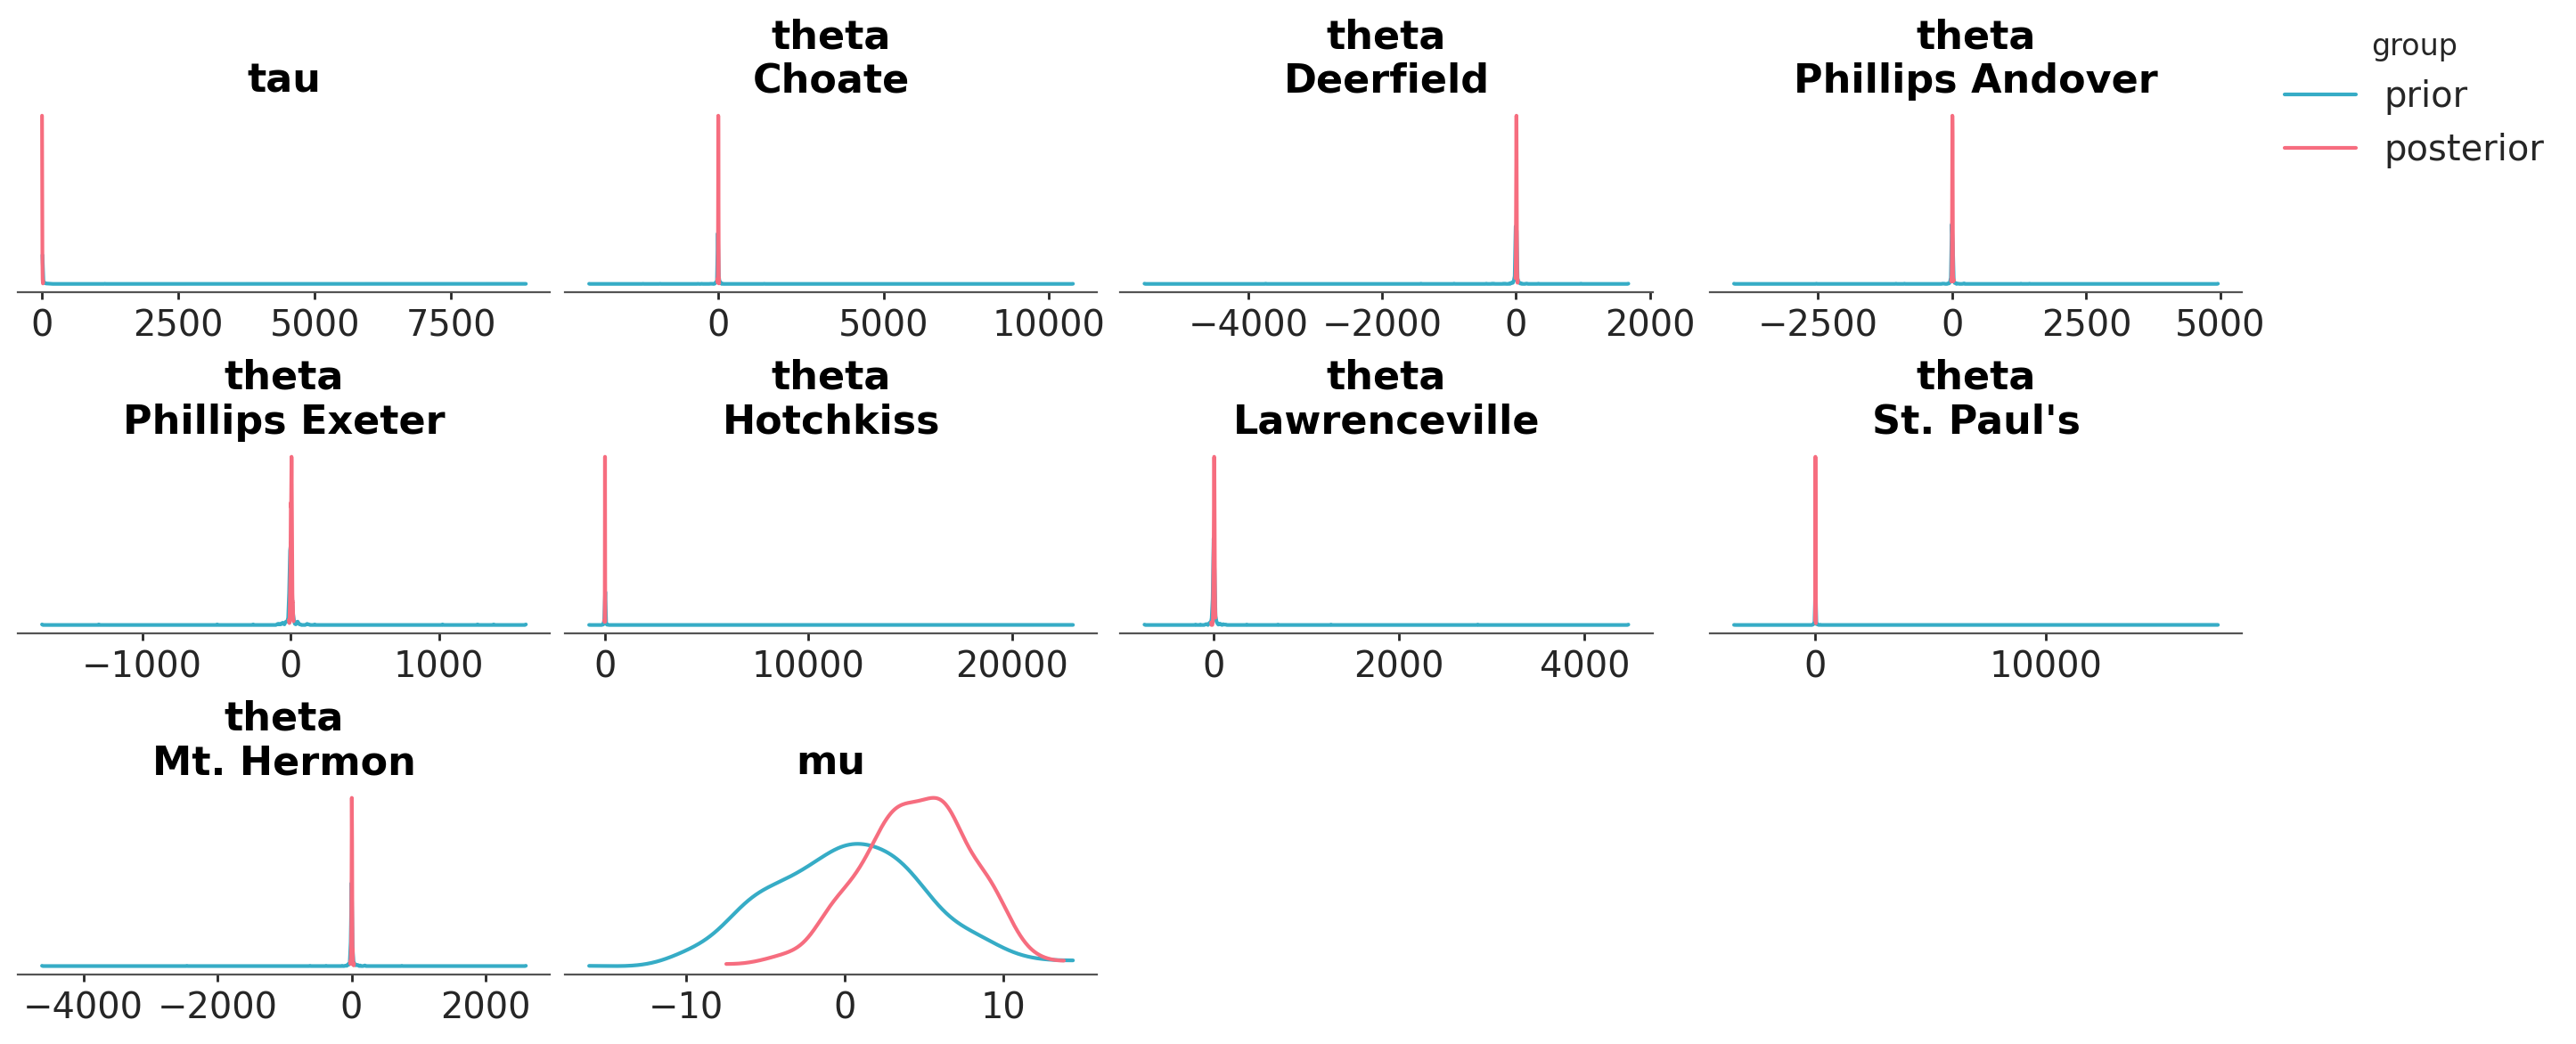

In [6]:
azp.plot_prior_posterior(data);

## ArviZ and DataTree

So far we have seen two functions, they both use the same input `data`, but generate different results. This is a common pattern in ArviZ, we pass an object like `data` and ArviZ generates a plot based on the function we call. This allows us to easily switch between different types of plots without having to change the underlying data structure. Internally ArviZ selects the necessary subset of the data to generate the plot. Thus, we don't need to worry about the details of how the data is organized or how to extract the relevant information for each plot, unless we want to.

In this example, `data` is a `DataTree` object; a flexible and efficient structure for storing and manipulating data in ArviZ. While DataTrees are used extensively in ArviZ, they are not specific to it; they are actually a core data structure in the [xarray](https://docs.xarray.dev/en/stable/) library. We rely on DataTrees because they offer a powerful way to represent multi-dimensional data with labeled axes, making it straightforward to work with complex datasets, including those generated during a Bayesian workflow, such as posterior samples, prior samples, and sampling statistics. This structure promotes clear organization and simplifies both data access and manipulation.

To keep this introduction short and simple we are going to focus our attention on some very general concepts related to DataTrees in the context of plotting with ArviZ. Details on how to work with DataTrees, and a description of other data-structures used by ArviZ, can be found in the [Working With DataTree](https://arviz-devs.github.io/EABM/Chapters/DataTree.html) guide. 


At a high level, a `DataTree` is a hierarchical structure with groups, the number of groups vary but within ArviZ we have a convention for the names of the groups. For instance, the posterior samples are stored in a group called `posterior`, the prior samples are stored in a group called `prior`, and the sampling statistics (stuff related to the inner workings of samplers) are stored in a group called `sample_stats`. This allows for a clear organization of the data, making it easy to access and manipulate.

Let's see the groups in `centered_eight`:

In [7]:
data.groups

('/',
 '/posterior',
 '/posterior_predictive',
 '/log_likelihood',
 '/sample_stats',
 '/prior',
 '/prior_predictive',
 '/observed_data',
 '/constant_data')

Each group can contain multiple variables. We already saw that we have `mu`, `theta`, and `tau`. And each variable can have multiple dimensions. For instance, the variable `mu` has a dimension called `chain`, which represents the different chains used in the MCMC sampling process, and a dimension called `draw`, which represents the different samples drawn from the posterior distribution. `theta` has these two dimensions plus a dimension called `school`, which represents the 8 schools in the model. 

In [8]:
data.posterior.data_vars

Data variables:
    mu       (chain, draw) float64 16kB 7.872 3.385 9.1 ... 1.767 3.486 3.404
    theta    (chain, draw, school) float64 128kB 12.32 9.905 ... 6.762 1.295
    tau      (chain, draw) float64 16kB 4.726 3.909 4.844 ... 2.741 2.932 4.461

This is a more complete view of the content of the posterior group

In [9]:
data.posterior

<xarray.DataTree 'posterior'>
Group: /posterior
    Dimensions:  (chain: 4, draw: 500, school: 8)
    Coordinates:
      * chain    (chain) int64 32B 0 1 2 3
      * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
      * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
    Data variables:
        mu       (chain, draw) float64 16kB 7.872 3.385 9.1 ... 1.767 3.486 3.404
        theta    (chain, draw, school) float64 128kB 12.32 9.905 ... 6.762 1.295
        tau      (chain, draw) float64 16kB 4.726 3.909 4.844 ... 2.741 2.932 4.461
    Attributes:
        created_at:                 2022-10-13T14:37:37.315398
        arviz_version:              0.13.0.dev0
        inference_library:          pymc
        inference_library_version:  4.2.2
        sampling_time:              7.480114936828613
        tuning_steps:               1000

## Exploring groups, dimensions and coordinates

By default, each "batteries-included" plot will use one or more of the available groups. For instance the `plot_dist` function will use the `posterior` group, while the `plot_prior_posterior` function will use both the `prior` and `posterior` groups. These two plots combine the `chain` and `draw` dimensions to produce the final plot. That's why we get a single plot for each variable (each one consisting of 2000 samples, 4 chains x 500 draws). But notice that the dimension `school` is not "reduced", instead it is used to facet the data, i.e. we get a separate plot for each school.

All these defaults can be changed, as we already saw with the `variable_names` argument. Usually ArviZ plotting function will have a `group` argument. How flexible this argument is depends on the function, one on extreme `plot_prior_posterior` ignores this argument and always uses the `prior` and `posterior` groups, while on the other extreme `plot_dist` is very flexible and allows us to specify many groups we may want to plot.


Let's set group to `posterior_predictive`. Can you anticipate what we will get?

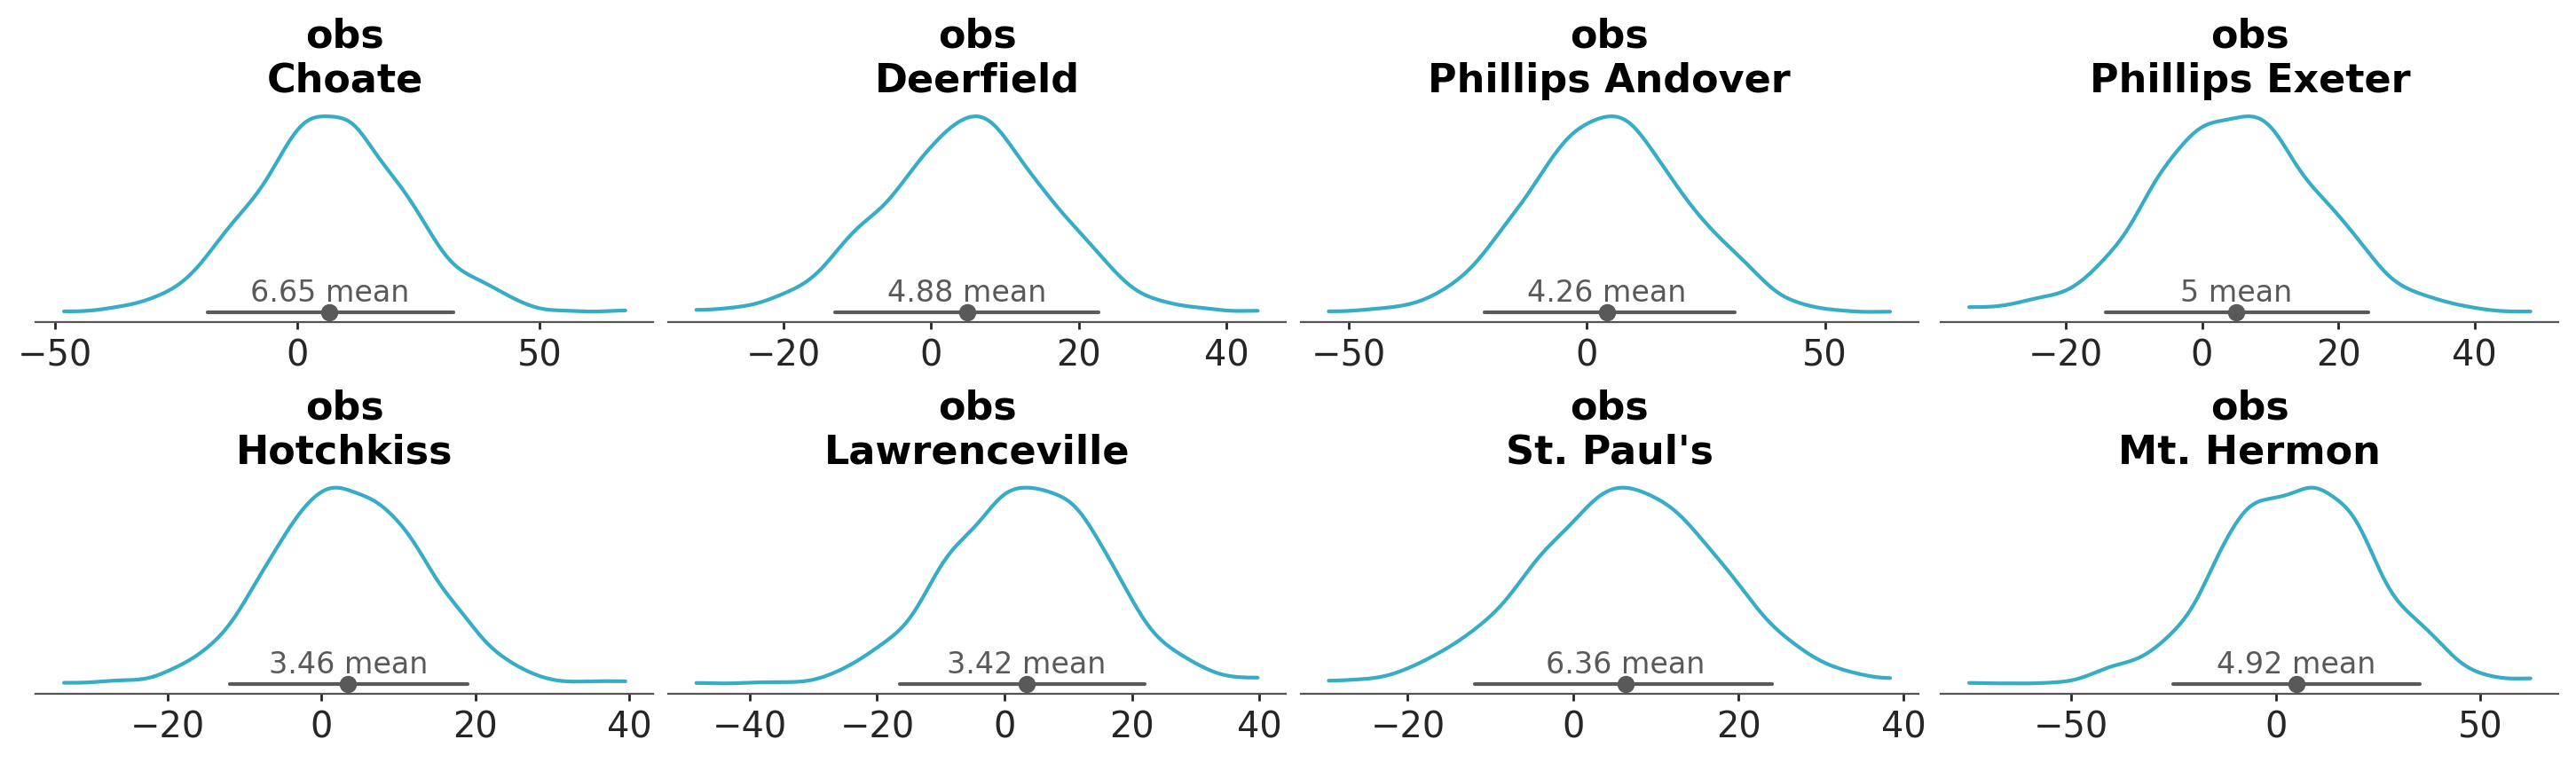

In [10]:
azp.plot_dist(data, group="posterior_predictive");

We get predictions of the model at each observation. In this example, we have 8 observations, so we get 8 plots.

ArviZ does not come with guarantees that any possible combination of arguments that you may want to try will work, or that the generated result will be sensible or useful. Defaults usually are, but then you are free to explore the data as you wish and be responsible for the results.


For instance

```python
az.plot_dist(data, group="sample_stats")
```

will not work, because the `sample_stats` group does not contain any samples to plot. However,

```python
azp.plot_dist(data, group="log_likelihood");
```

will work, and it will plot the log-likelihood of the model for each observation. How useful is this, it depends on the context the analysis. 


Results may vary for different models, for instance.

```python
dt = azp.load_arviz_data("radon")
azp.plot_dist(dt, group="posterior_predictive");
```

will run, but it may crash your session, because for the `radon` model the `posterior_predictive` group contains 919 observations. So the above code will try to plot 919 KDEs!, which may be too much for your system to handle. 

Because checking the posterior predictive distribution is a common task in Bayesian data analysis, ArviZ provides several specialized functions for this purpose. One of them is `plot_ppc_dist`. This function is designed to handle posterior predictive checks and will produce a more sensible plot than `plot_dist` when used with the `posterior_predictive` group. In the followings example we use the empirical cumulative distribution function [ECDF](https://arviz-devs.github.io/EABM/Chapters/Distributions.html#ecdf) to visualize the posterior predictive distribution of the model. 

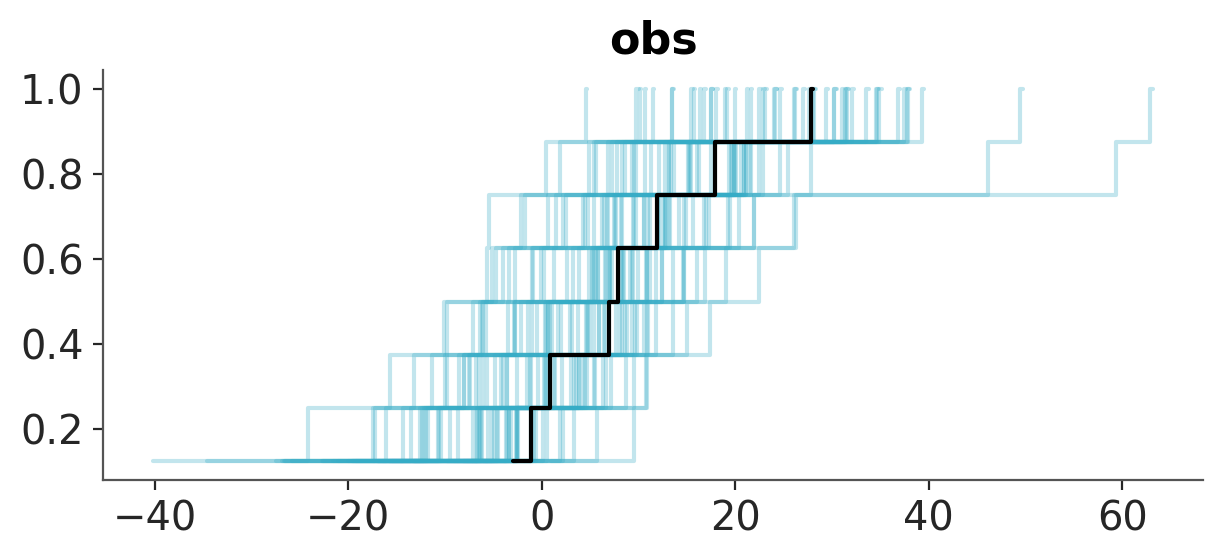

In [11]:
# try using dt = azp.load_arviz_data("radon")
azp.plot_ppc_dist(data, kind="ecdf");

We want to note that you can use `.plot_dist(dt, group="posterior_predictive")` to do posterior predictive checks, actually `plot_ppc_dist` is using it. However, it will require more effort on your part, as you will need to adjust several other arguments and take additional steps to obtain a meaningful result.

### Sample_dims

Now, we are going to discuss the `sample_dims` argument. This argument is used to specify which dimensions of the data should be reduced when plotting. An example will help us understand this better. Let's say we want to use the `plot_dist` function to visualize the distribution of the data. If we do:

```python
azp.plot_dist(data, group="observed_data");
```

We will get an error, ArviZ will attempt to generate one plot per observation, and we can not compute a KDE (or ECDF or histogram) with a single point. By default, `sample_dims` is set to `["chain", "draw"]`, but those dimensions are not present (or meaningful) in the `observed_data` group. What we want to do is to plot the marginal distribution of the observed data, i.e. we don't care about which school the data comes from, we just want to see the distribution of the observed data across all schools. So, we can change `sample_dims` to `["school"]`.

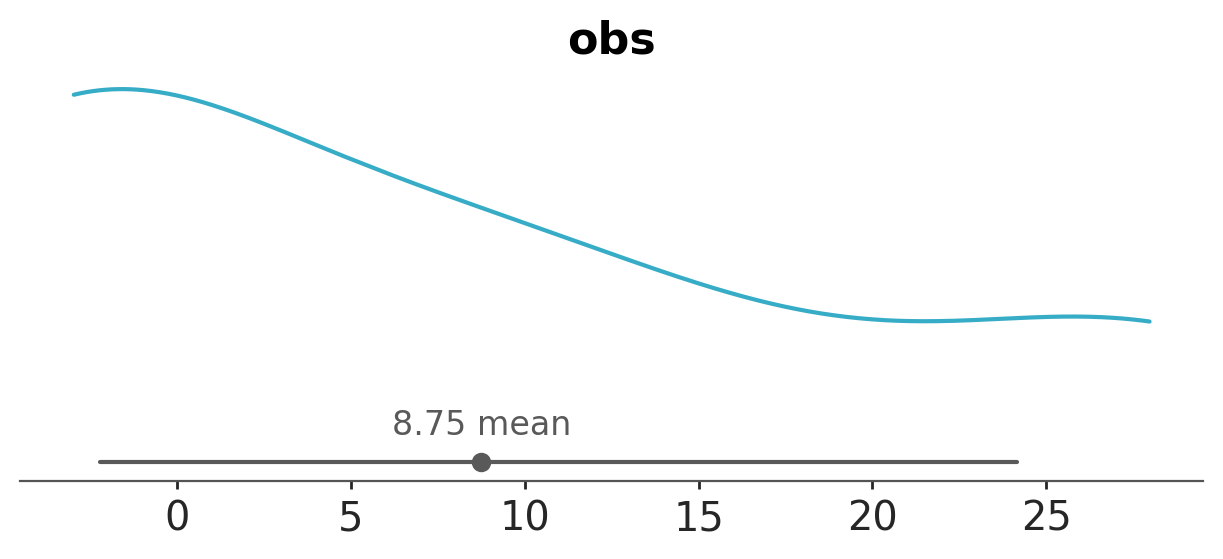

In [12]:
azp.plot_dist(data, group="observed_data", sample_dims=["school"]);

If we were interested in the posterior distribution for `mu` per `chain`, we could do:

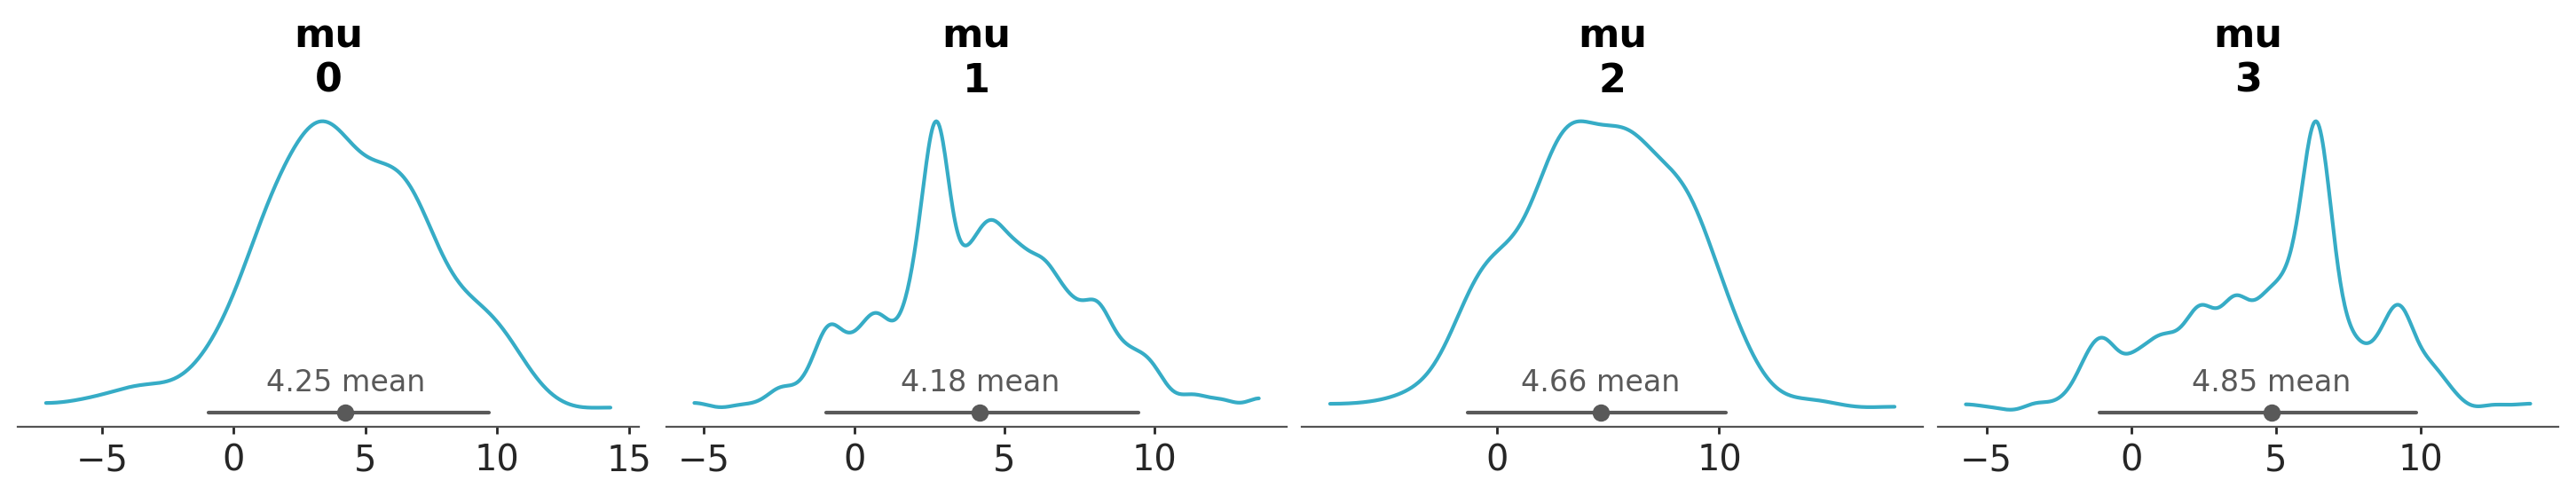

In [13]:
azp.plot_dist(data,
              var_names=["mu"],
              sample_dims=["draw"]);

A KDE that appears overly spiky or irregular may indicate issues with specific chains, such as poor convergence or pathological sampling behaviour. However, diagnosing these issues is beyond the scope of this tutorial, to learn more about MCMC diagnostics, please refer to the [MCMC Diagnostics](https://arviz-devs.github.io/EABM/Chapters/MCMC_diagnostics.html) chapter from the EABM guide.

### Coords

We can use the `coords` argument to specify which **coordinates** we want to use for the plot. This is useful to filter variables across dimensions. For instance, if we want to plot the posterior distribution of only a subset of schools, we can do:

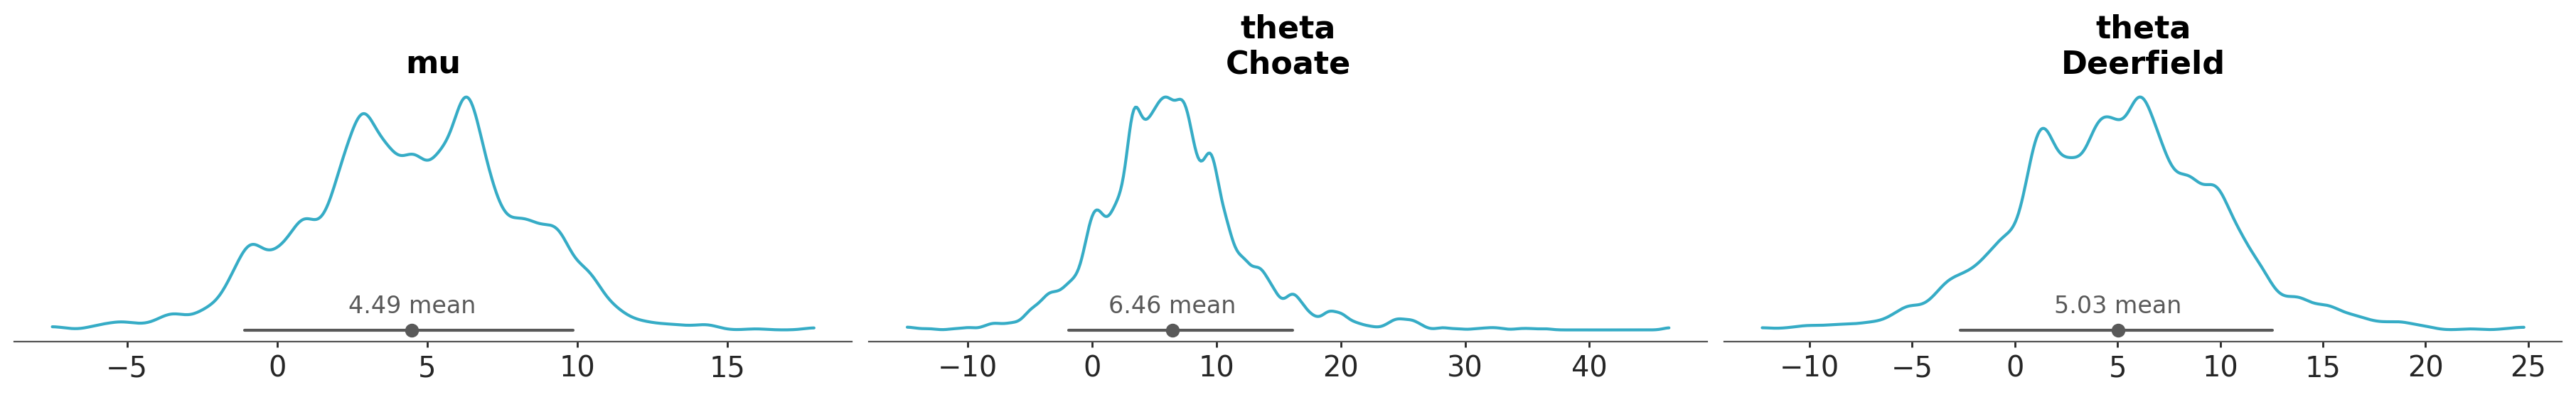

In [14]:
azp.plot_dist(data,
              var_names=["mu", "theta"],
              coords={"school": ["Choate", "Deerfield"]},
              );

Notice that the `coords` argument is used to select specific schools and thus it does not affect variables without the school dimension, like `mu`.

## Global defaults

ArviZ provides a set of global defaults that, once modified, influence the behaviour of multiple functions across the library. ArviZ's plots, like `plot_dist` takes from here the default value for `sample_dims` and other arguments. They are stored in `azb.rcParams`, for further details you can read {ref}`arviz_base:arviz_configuration`. Can you spot, the default values for interval and their probability?

In [15]:
azb.rcParams

RcParams({'data.http_protocol': 'https',
          'data.index_origin': 0,
          'data.sample_dims': ('chain', 'draw'),
          'data.save_warmup': False,
          'plot.backend': 'matplotlib',
          'plot.density_kind': 'kde',
          'plot.max_subplots': 40,
          'stats.ci_kind': 'eti',
          'stats.ci_prob': 0.89,
          'stats.ic_compare_method': 'stacking',
          'stats.ic_pointwise': True,
          'stats.ic_scale': 'log',
          'stats.module': 'base',
          'stats.point_estimate': 'mean'})

If we don't like the default value of 0.94 for the credible interval, we can change it globally:

```python
azb.rcParams["stats.ci_prob"] = 0.95
```

This will change the default value for the credible interval to 0.95 for all subsequent calls to `plot_dist` and other functions that use this parameter, or we can change it per call:

```python
azp.plot_dist(data, group="posterior", ci_prob=0.95)
```

## More about arguments

Some arguments are shared across all (or almost all) plotting functions, like `var_names`, `group`, and `sample_dims`. These arguments allow us to customize the plots by selecting which variables to display, which group of data to use, and how to reduce the dimensions of the data. Other arguments are specific to each plotting function (or related functions). For instance, we have seen that `plot_dist` has a `kind` argument that allows us to choose the type of plot we want to generate, such as a KDE, histogram, or ECDF. Or `ci_prob` that allows us to set the probability for the credible interval. 

We are now going to discuss some arguments that are central to the ArviZ plotting functions and that will help us understand how to customize the plots further.

### visuals

If you inspect the documentation for `plot_dist` you may notice that there are no arguments with names like `color`, `linestyle` or `figsize`. Nor arguments like `bins` or `bandwidth` that are common in other plotting libraries. That does not mean that you can not change them, it just means that you will need to use "dictionary arguments". The rationale behind this is that ArviZ aims to provide a flexible and consistent interface for plotting, by using dictionary arguments we allow for flexibility in customizing the plots without cluttering the function signature with too many arguments.

For example to change the colors of the KDEs we can do:

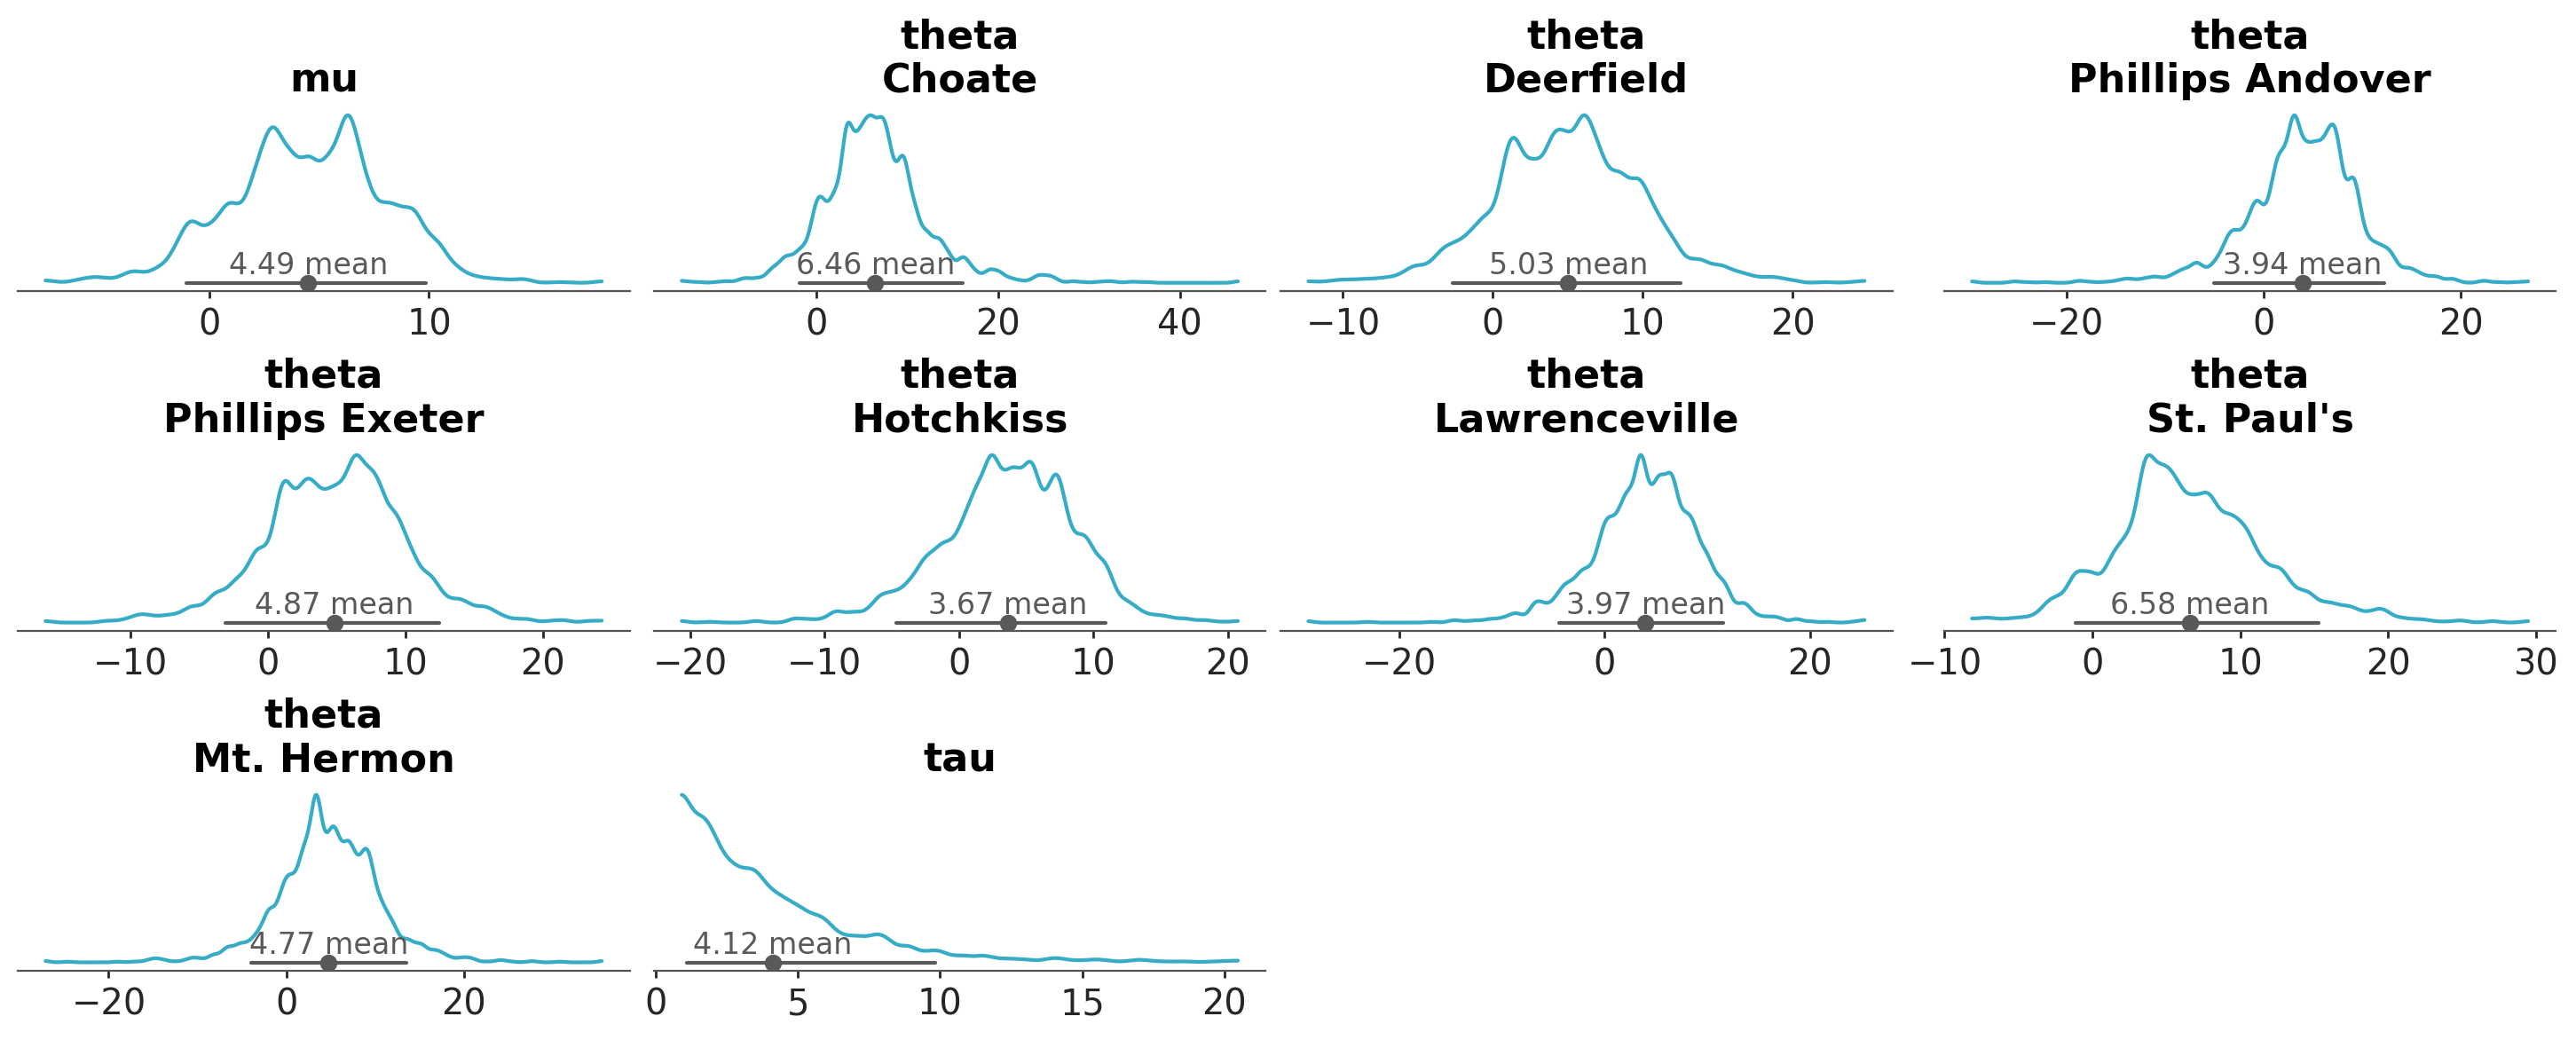

In [16]:
azp.plot_dist(data, visuals={"kde": {"color": "darkorchid"}});

Hopefully, the example above provides a hint of how to use the `visuals` argument. But, let's go through it in more detail.

In ArviZ, we use the {term}`visual` to reference to the graphical elements we see in a plot, like a title, a KDE, a credible_interval, etc. 

The valid keys for the dictionary passed to the `visuals` argument, are graphical elements and the values are passed to internal functions that are in charge to represent each of those graphical elements.

To find the valid keys for `visuals`, you can check the docstring of each function. For `plot_dist` we have:

* One of "kde", "ecdf", or "hist", matching the `kind` argument.
* credible_interval
* point_estimate
* point_estimate_text
* title
* rug
* remove_axis


Notice how all these `keys` are related to the graphical elements of previous plot. Except for `rug` that is not shown by default and `remove_axis` that allows us to remove the `y-axis` from the plot. 

Let's play a bit with the `visuals` argument, so we get more familiar with it. Let's plot a [histogram](https://arviz-devs.github.io/EABM/Chapters/Distributions.html#histograms) and change the transparency and color of the bars:

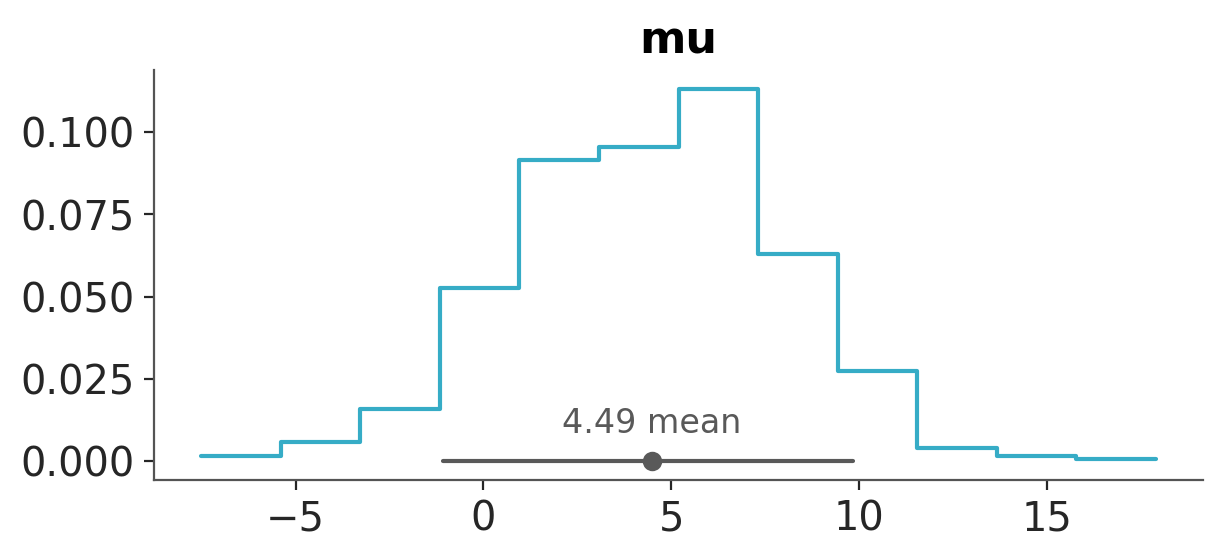

In [17]:
azp.plot_dist(data,
              var_names=["mu"],
              kind="hist",
              visuals={"hist": {"alpha": 0.5, "color": "darkorchid"}},
              );

To plot a step-like histogram, without the `y-axis` and without the text for the `point_estimate_text`.

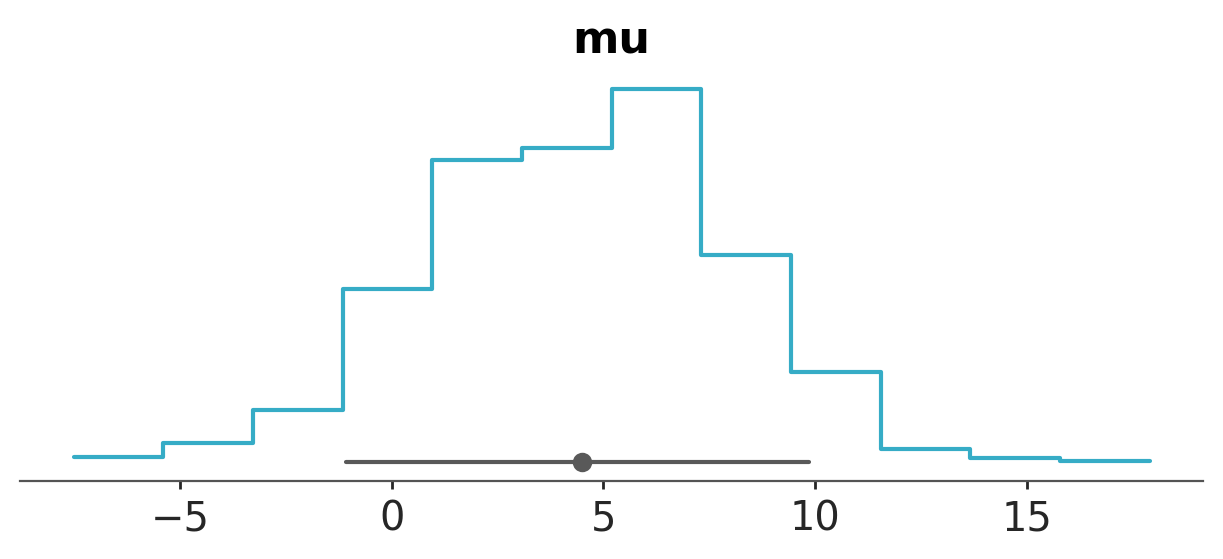

In [18]:
azp.plot_dist(data,
              var_names=["mu"],
              kind="hist",
              visuals={"hist": {"step": True},
                       "remove_axis":True, # this can only be True or False
                       "point_estimate_text":False, # this can only be False or some value valid for text like "fontsize" or "color"
                        },
              );

A note on `"remove_axis"`: Internally, there's a function that can remove the x-axis, y-axis, or both. In the case of `plot_dist`, it's hardcoded to remove the y-axis. The reasoning is that the x-axis always carries meaningful information for `plot_dist`, whereas the y-axis may not.

### stats

If instead of changing visual properties, like colors, we want to change statistical properties, like the number of bins used for a histogram we must use the argument `stats`.

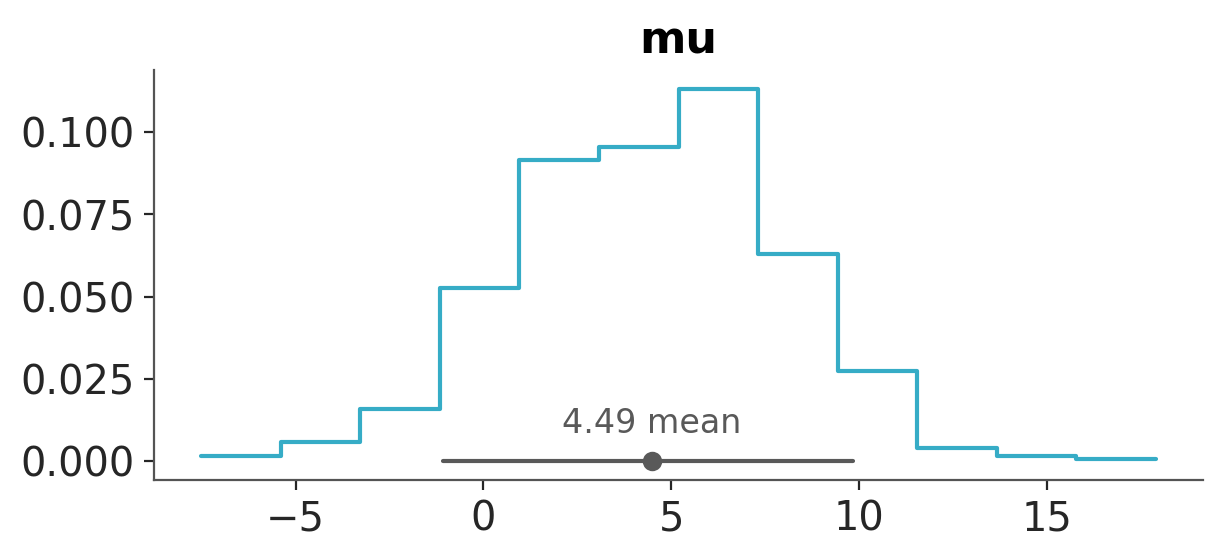

In [19]:
azp.plot_dist(data,
              var_names=["mu"],
              kind="hist",
              stats={"density": {"bins": "auto"}},
              );

Notice that this time the key `density` does not need to match the `kind` argument. Also notice than in general, if you pass values that are not valid for a specific computation, they will be ignored. For instance, if you pass `{bins:10}` to a KDE plot, it will be ignored, because KDEs do not use bins.

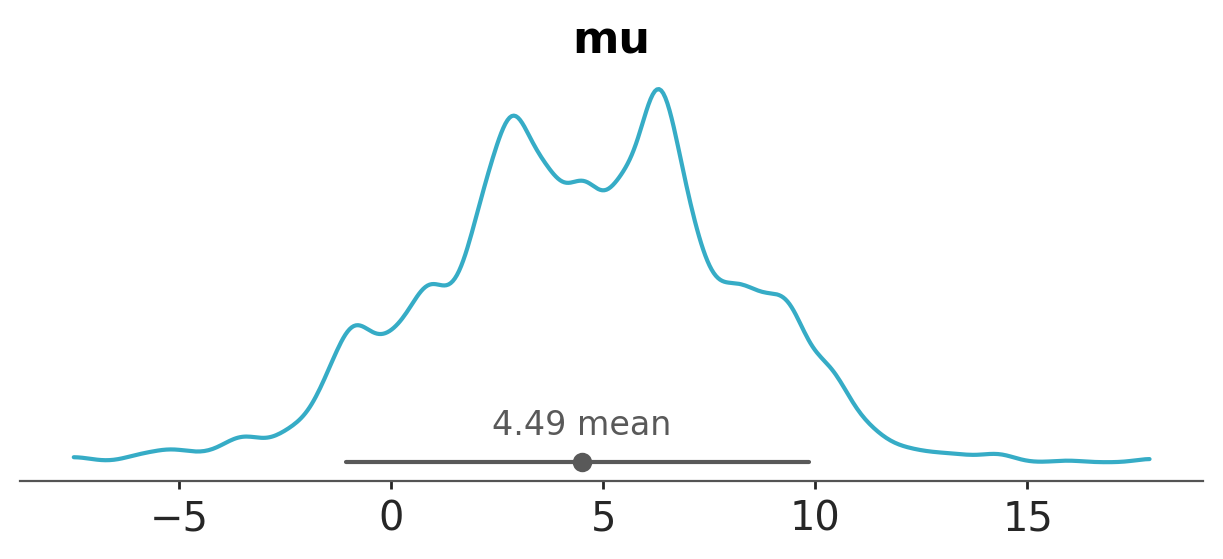

In [20]:
azp.plot_dist(data,
              var_names=["mu"],
              kind="kde",
              stats={"density": {"bins": 10}},  # this does not affect the KDE
              );

To see the valid keys check the docstring for each function, for `azp.plot_dist` they are:

* density. Controls how the KDE, Histogram or ECDF are computed.
* credible_interval. Control how the equal-tailed interval (ETI) or highest density interval (HDI) are computed.
* point_estimate. Control how the mean or median are computed.

### pc_kwargs and aes_by_visuals

Another argument is `pc_kwargs`, we can use is to change the number of columns.

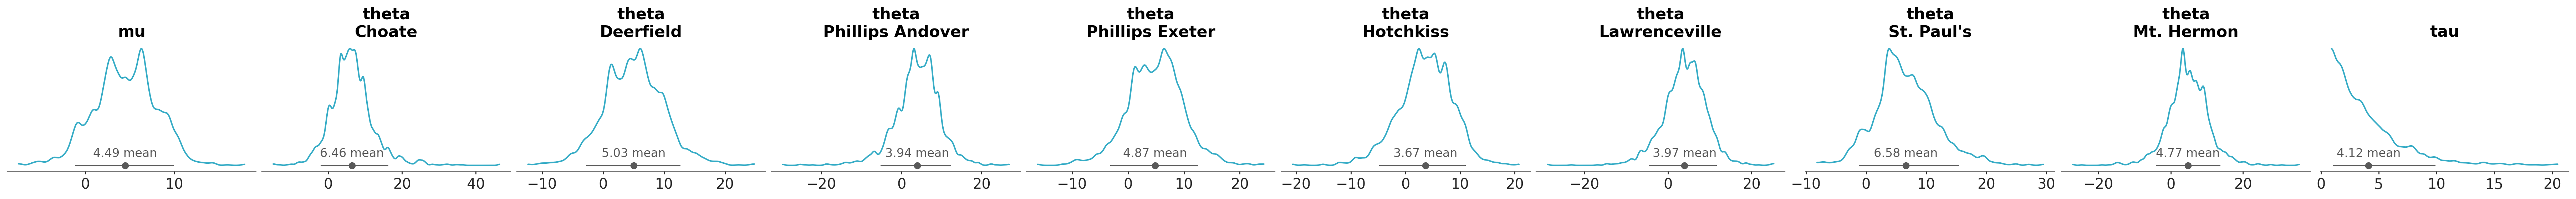

In [21]:
azp.plot_dist(
    data,
    col_wrap=10,
);

Or change the figure size

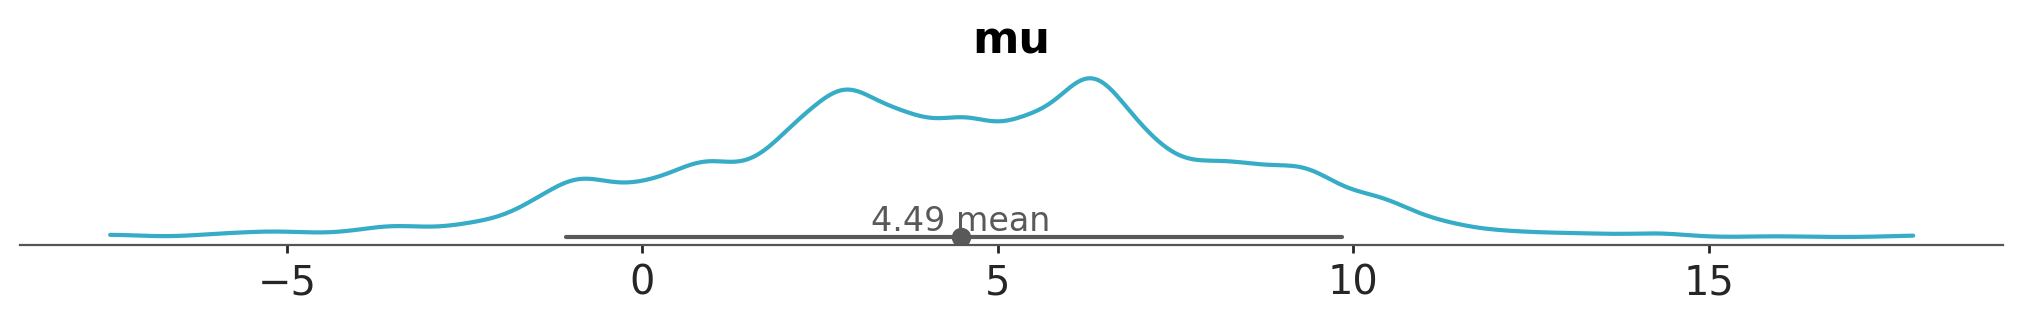

In [22]:
azp.plot_dist(
    data,
    var_names=["mu"],
    figure_kwargs={"figsize": (10, 1.5)},
);

Or we can map a color to a variable in the data.

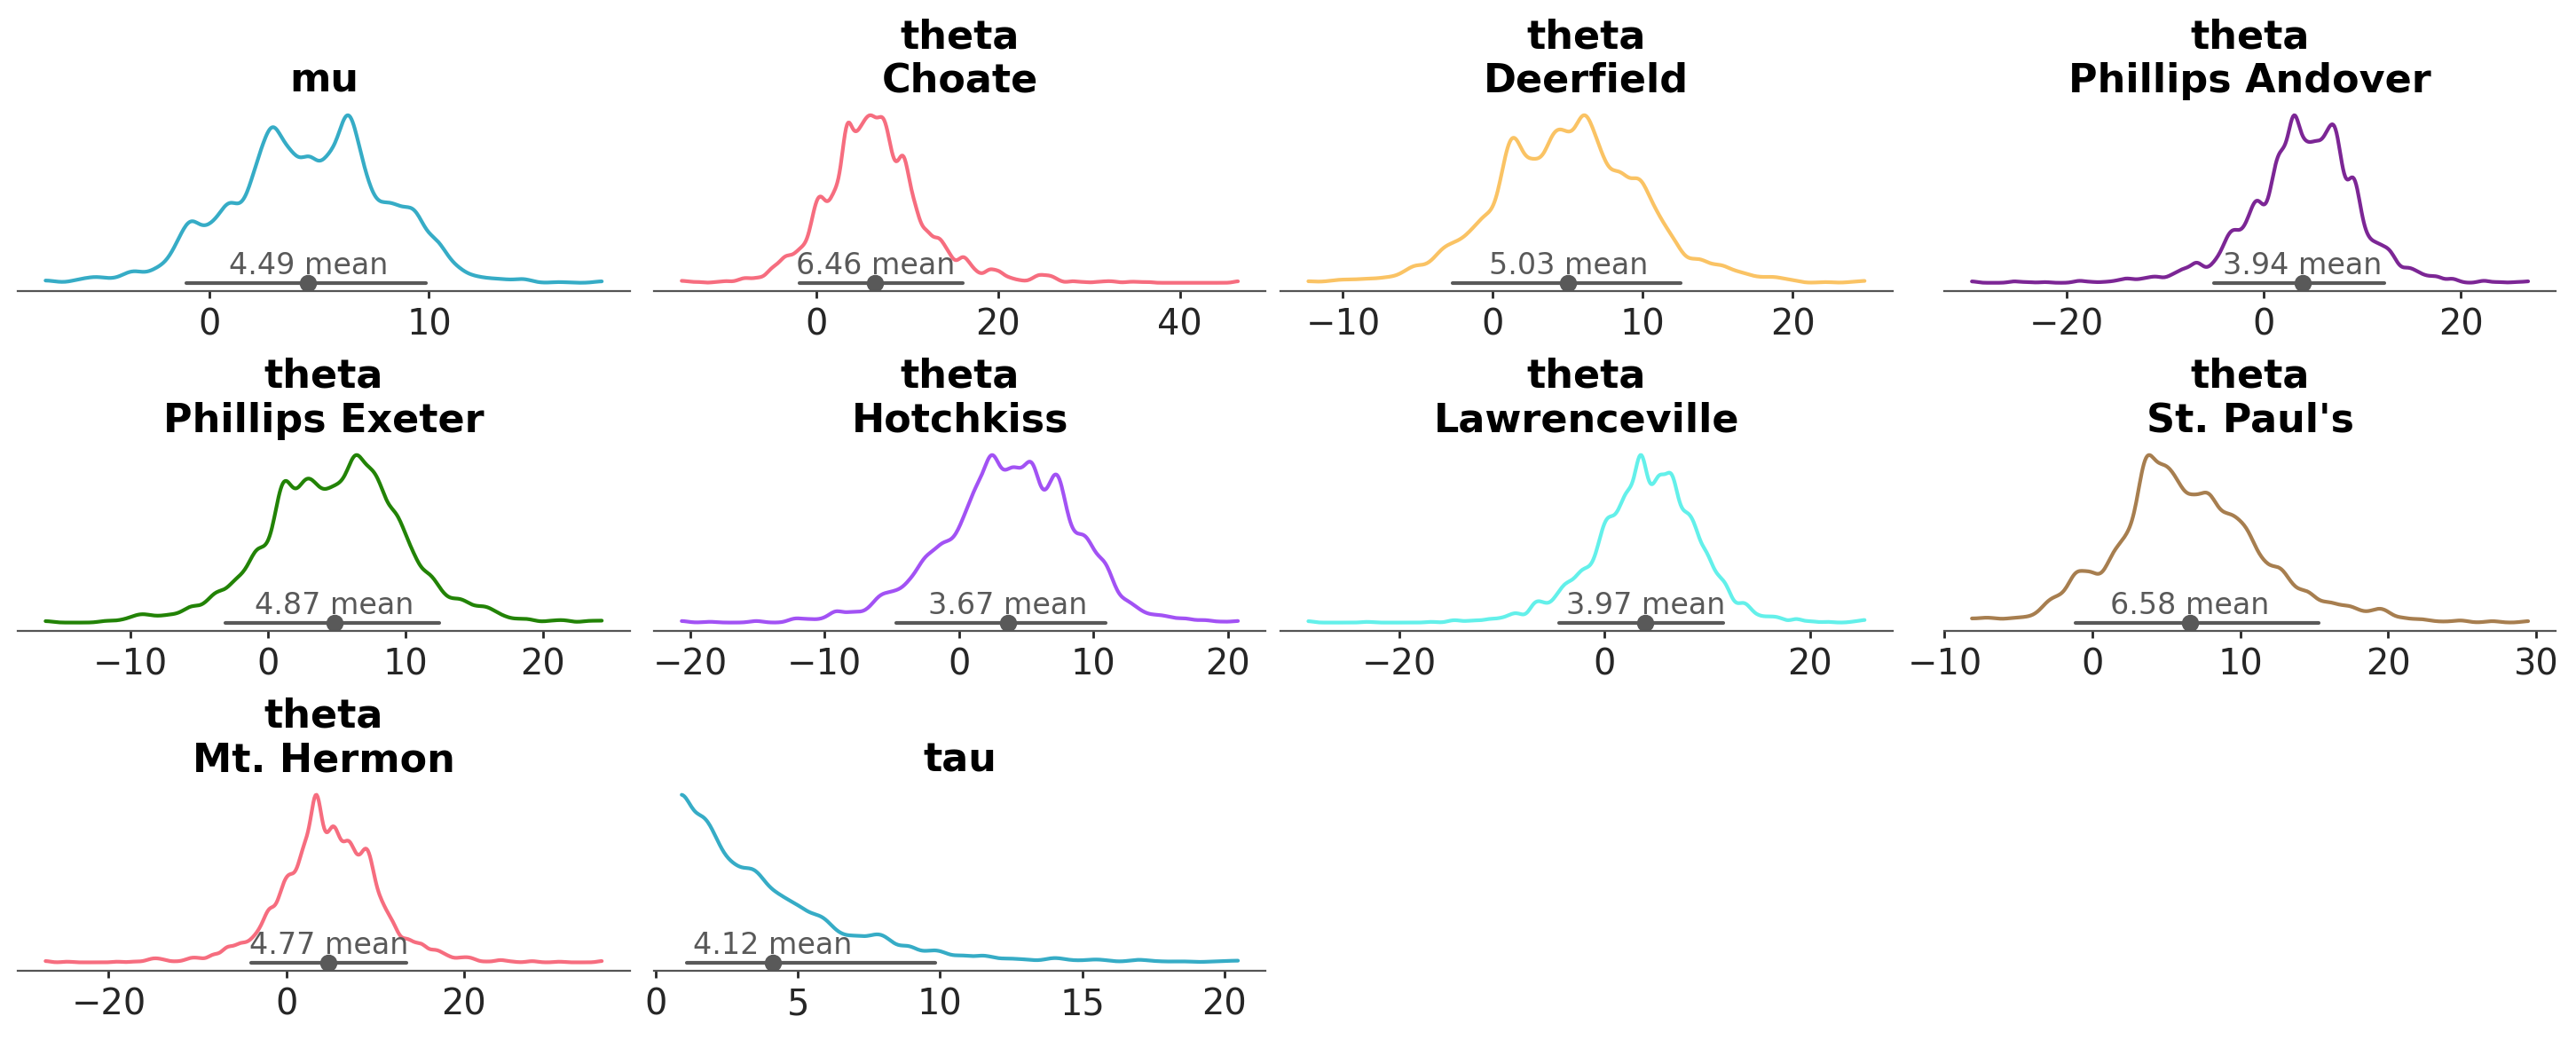

In [23]:
azp.plot_dist(
    data,
    aes={"color": ["school"]},
);

The name `aes` comes from the term **aesthetics**. We use aesthetic for a graphical property that is being used to encode data. In this case we use color to encode the `school` dimension. Because the variables `mu` and `tau` don't have that dimension they are assigned the same color. We say this color is "neutral" because is not encoding any specific information.

In the previous example we told ArviZ to map the `color` argument to the `school` dimension. But that did not affect other visuals than the "kde". That makes as wonder at least two questions, why? And how to change the color of other visuals, like the credible and point estimates? 

The answer to the first question is that the `color` argument by default is only mapped to the KDE (or the ECDF or the histogram, depending on the `kind` argument). The answer to the second question is that we can change that by using the `aes_by_visuals` argument.

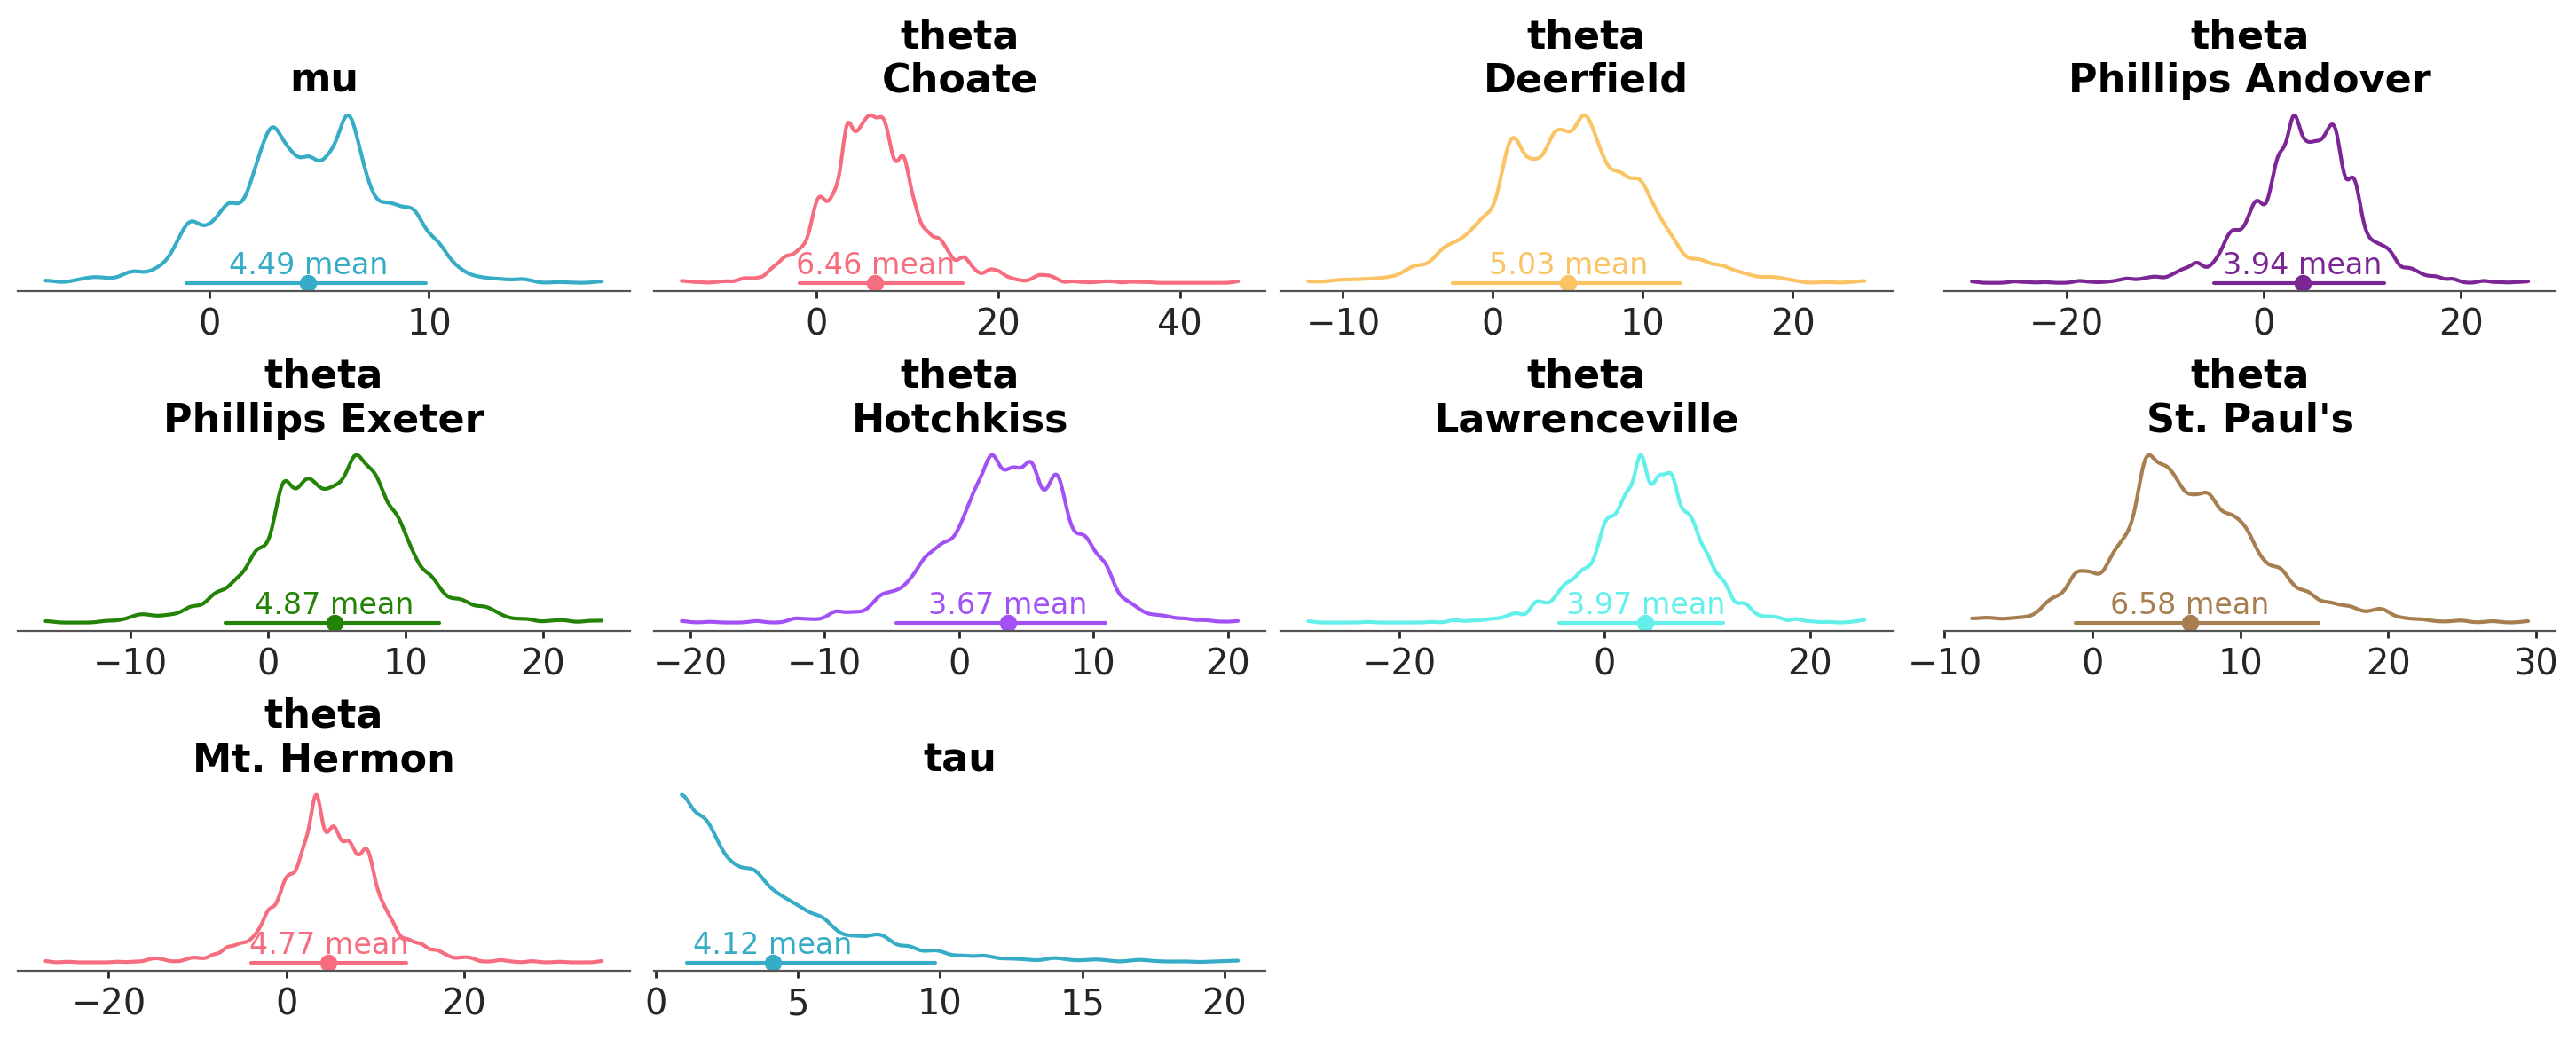

In [24]:
azp.plot_dist(
    data,
    aes={"color": ["school"]},
    aes_by_visuals={
        #"kde": ["color"], # this is the default, so it can be omitted
        "point_estimate": ["color"],
        "credible_interval": ["color"],
    },
);


## PlotCollection: Peeking Under the Hood

Compared to `visuals` and `stats` the name `pc_kwargs` may not be that obvious, at least at first. So let's fix that. The "`pc`" stands for `PlotCollection`. ArviZ plots are generated by first populating a `PlotCollection` object with the graphical elements that will be used to generate the final figure. PlotCollection provides the logic to loop over each plot, assign the correct data, aesthetics, and other properties to each plot, and then render them in a single figure. You can learn about it in the {ref}`intro to PlotCollection  <use_plotcollection>` tutorial.

When using batteries-included plots you don't need to directly interact with PlotCollection, you will only need it, if you want to create {ref}`your custom plot <compose_own_plot>`, or to perform some tweaks that can not be achieved via the provided arguments. For instance, to manually set the limit of the x-axis for the variable `mu` we can do:

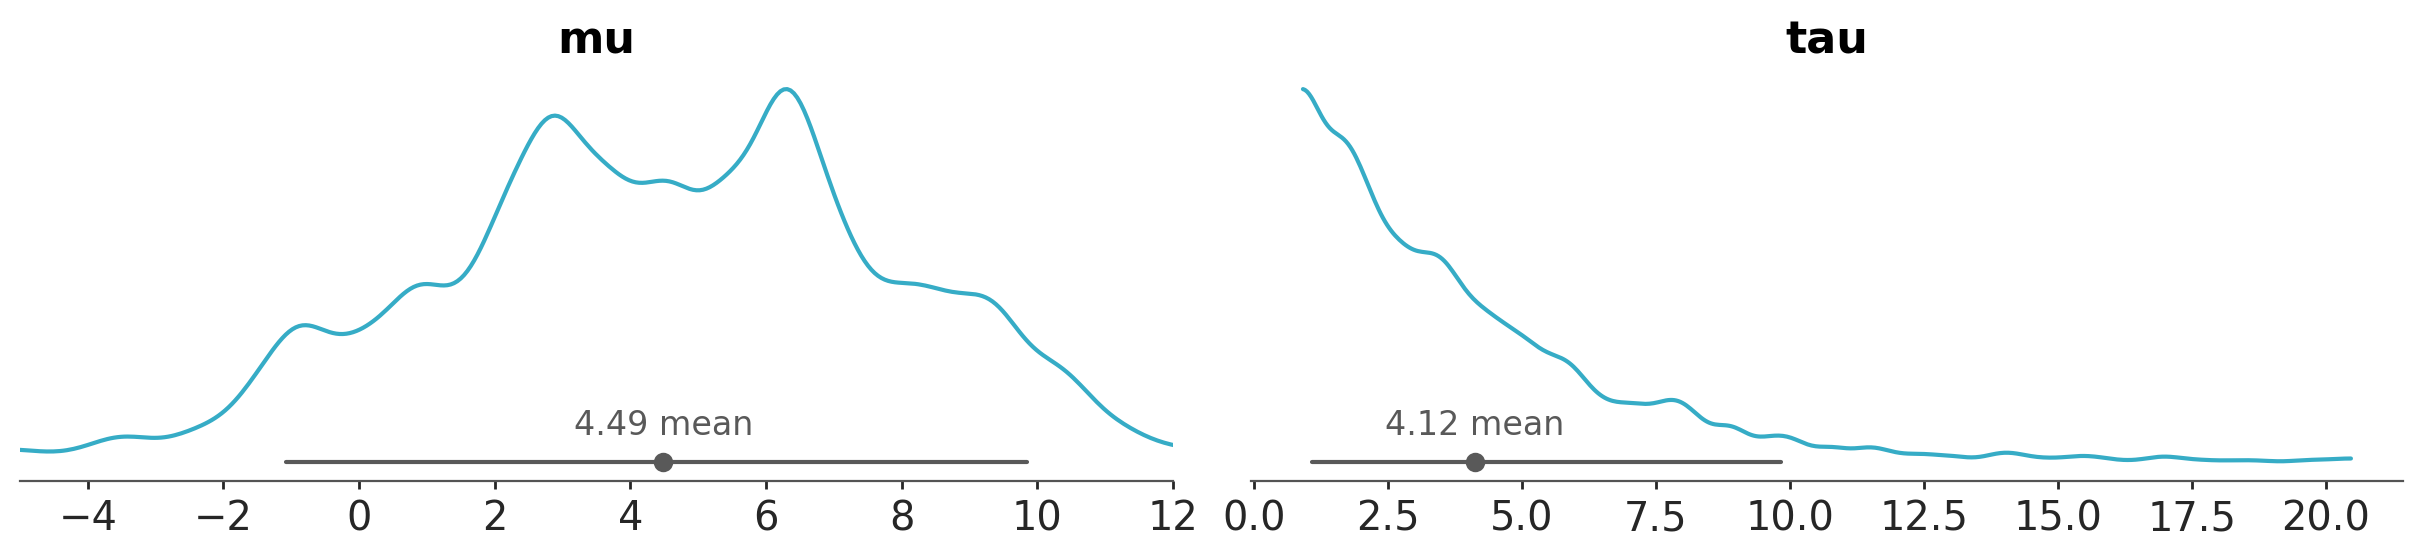

In [25]:
pc = azp.plot_dist(
    data,
    var_names=["mu", "tau"],
)

pc.get_viz("plot", "mu").set_xlim(-5, 12);

This works because a PlotCollection object stores information like the matplotlib axes, that we can access and modify directly.

In [26]:
pc.get_viz("plot", "mu")

<Axes: title={'center': 'mu'}>

## Plotting backends

So far we have being using the matplotlib backend, but tree other backends are available, `plotly`, `bokeh`, and `none`. The first two produce actual plots, while the last one does not produce any plot. Again, for most common use you should not need to worry about the `none` backend. Which backend to use depends on your needs and preferences. To use the backend you need to have it installed, you can have one, two, or all of them installed at the same time. You can globally set the backend by changing the value of:

```python
azb.rcParams["plot.backend"]
```

or using the `backend` argument in the plotting function.

One important thing to understand is that the "structure" of PlotCollection is the same for all backends, but the actual information stored will change. For example

In [27]:
pc = azp.plot_dist(
    data,
    var_names=["mu", "tau"],
    backend="plotly"
);
print(pc.get_viz("plot", "mu"))

See, we can still access `pc.get_viz("plot", "mu")`, but its content is not the same as before.

### Backend agnostic functionality
Support for the multiple backends comes from ArviZ knowing how to forward the arguments correctly, e.g. `facecolor` in matplotlib is equivalent to `fill_color` in bokeh. The values themselves are generally passed as is to the plotting backend, with one important exception. As you have seen when discussing `pc_kwargs`, you only need to say `aes={"color": ["school"]}` to define an {term}`aesthetic mapping`. It is not necessary to define the cycle of aesthetic values to use in the mapping. This extends also to `linestyle` and `marker`.

Moreover, ArviZ plots are now aware of the background color and set the text, labels and titles accordingly:

In [28]:
azp.style.use("arviz-tumma")

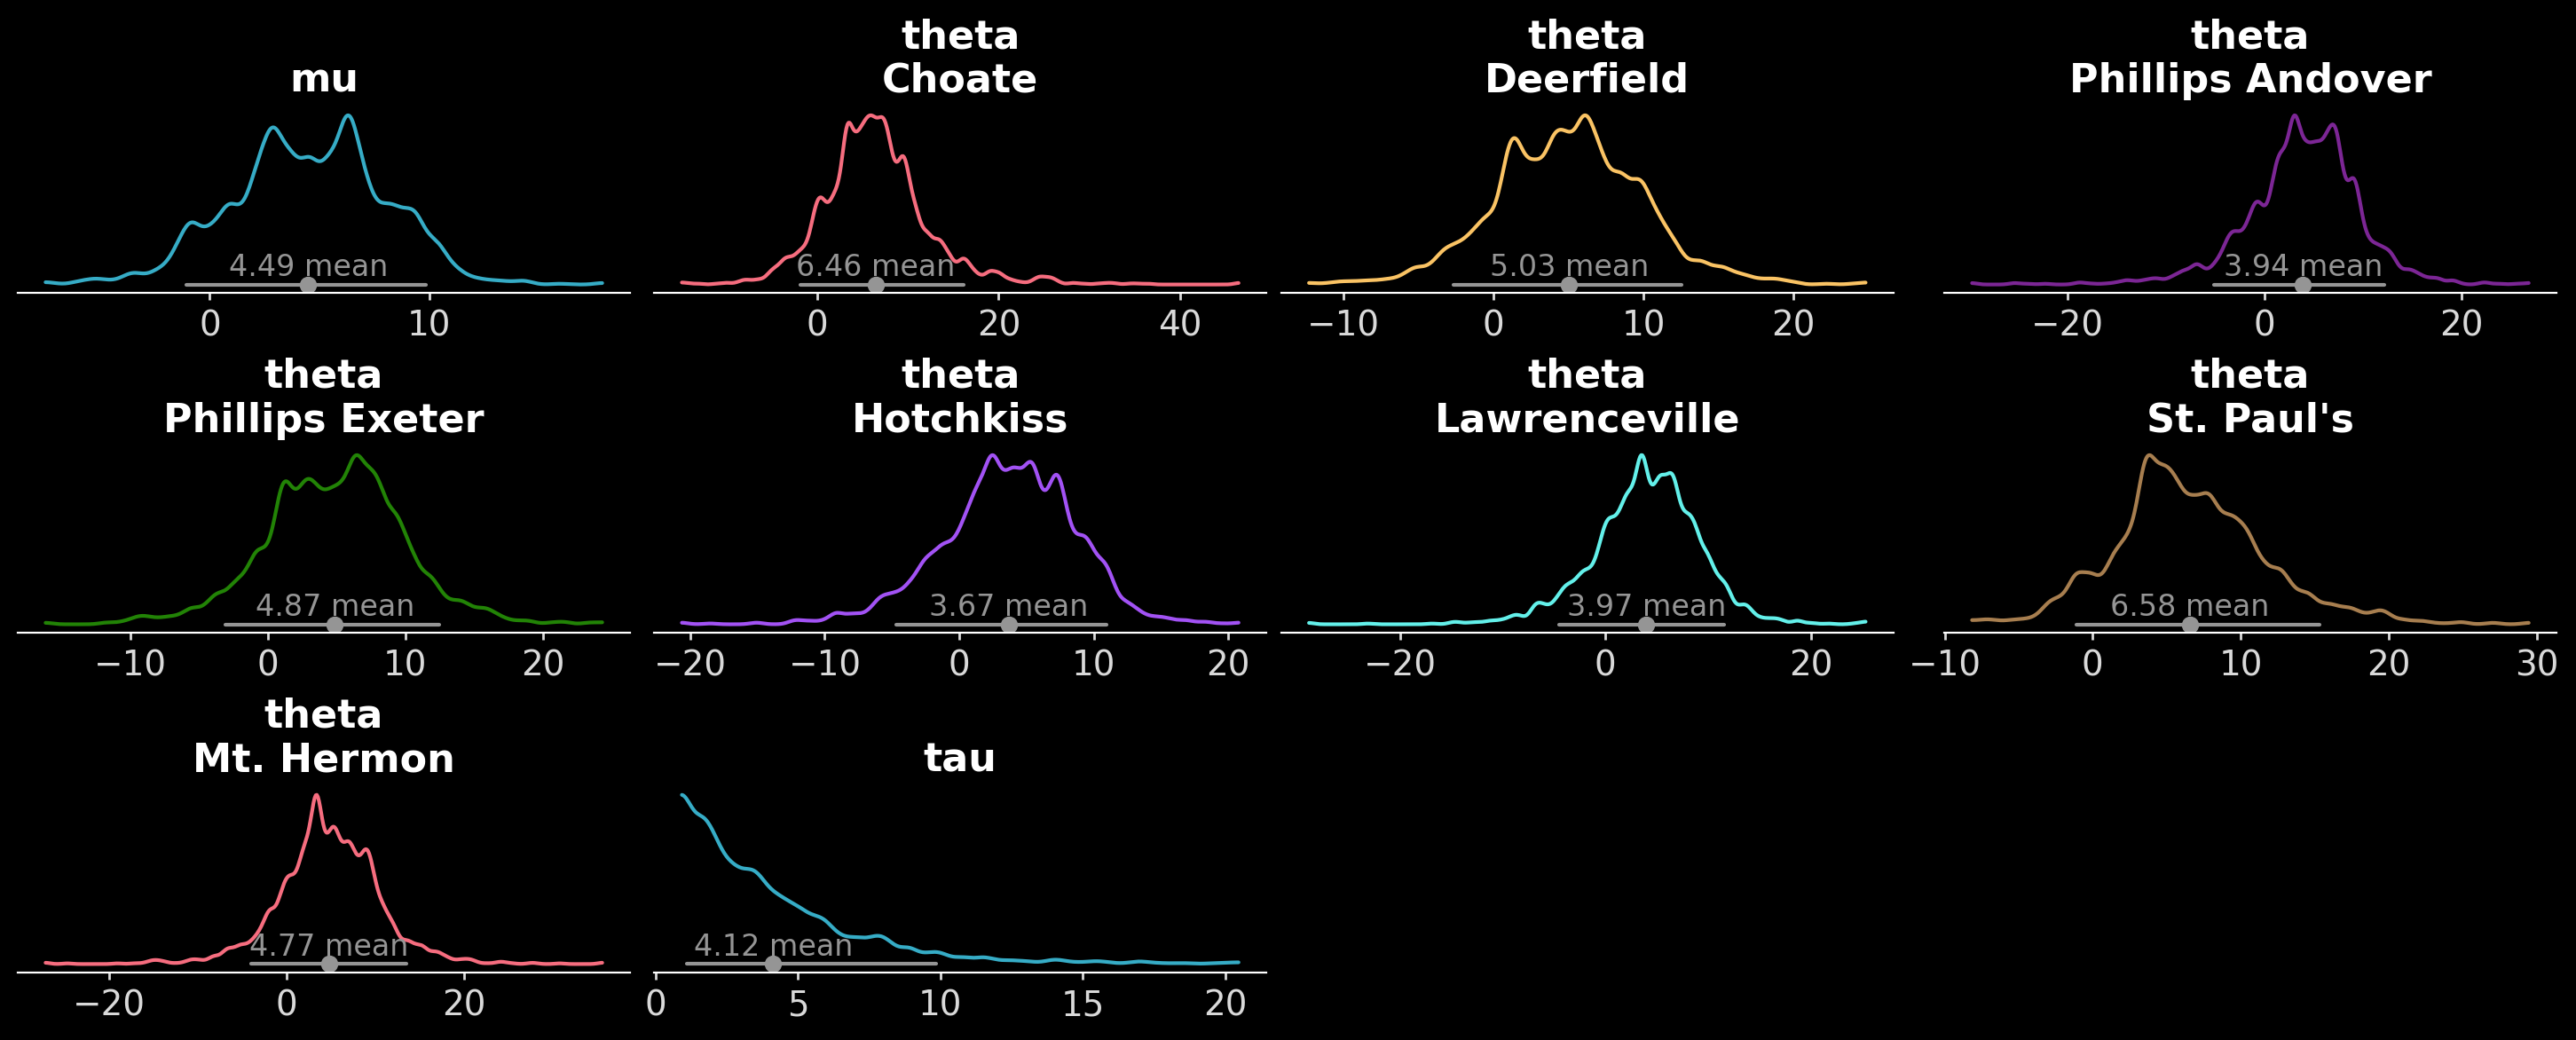

In [29]:
azp.plot_dist(data, aes={"color": ["school"]});

To help users interact with these default aesthetic cycles and define defaults or even whole plots that are backend and theme agnostic, arviz-plots provides the following aliases:

* `CX` indicates the x-th element of the default aesthetic cycle of that property. These are consequently affected by changes in the underlying backend themes but not by definitions of the aesthetic cycle at the `PlotCollection` level. `CX` aliases like `C2` or `C11` are valid for `color`, `edgecolor`, `facecolor`, `linestyle` and `marker`.
* `BX` indicates background dependent values. These are only valid for `color`, `edgecolor` and `facecolor`; and are limited to 0-3 indexes:
  - `B0` -> the background color of the currently active theme
  - `B1` -> a color with high contrast with `B0` (21:1 for black or white backgrounds)
  - `B2` -> a color with muted contrast with `B0` (7:1 contrast for black or white backgrounds). This color is more muted than `B1` but still high contrast enough for accessible text within image or thin visual elements.
  - `B3` -> a color with muted contrast with `B0` (3:1 contrast for black or white background). This color is even more muted than `B2` and might not be easily readable for everyone. It is still adequate for complementary graphical elements like grid lines or borders.

In the figure above and previous uses of `plot_dist` we can see the `BX` aliases in action. The color of the title is set to `B1` which dealiases to black for the default white background but to white now that we are using the dark theme. The color of the credible interval, point estimate and point estimate text is set to `B2` instead which dealiases to dark/light gray respectively. The `BX` aliases can also be used as alternatives to the named gray colors in order to ensure the generated figure will accessibility guidelines.

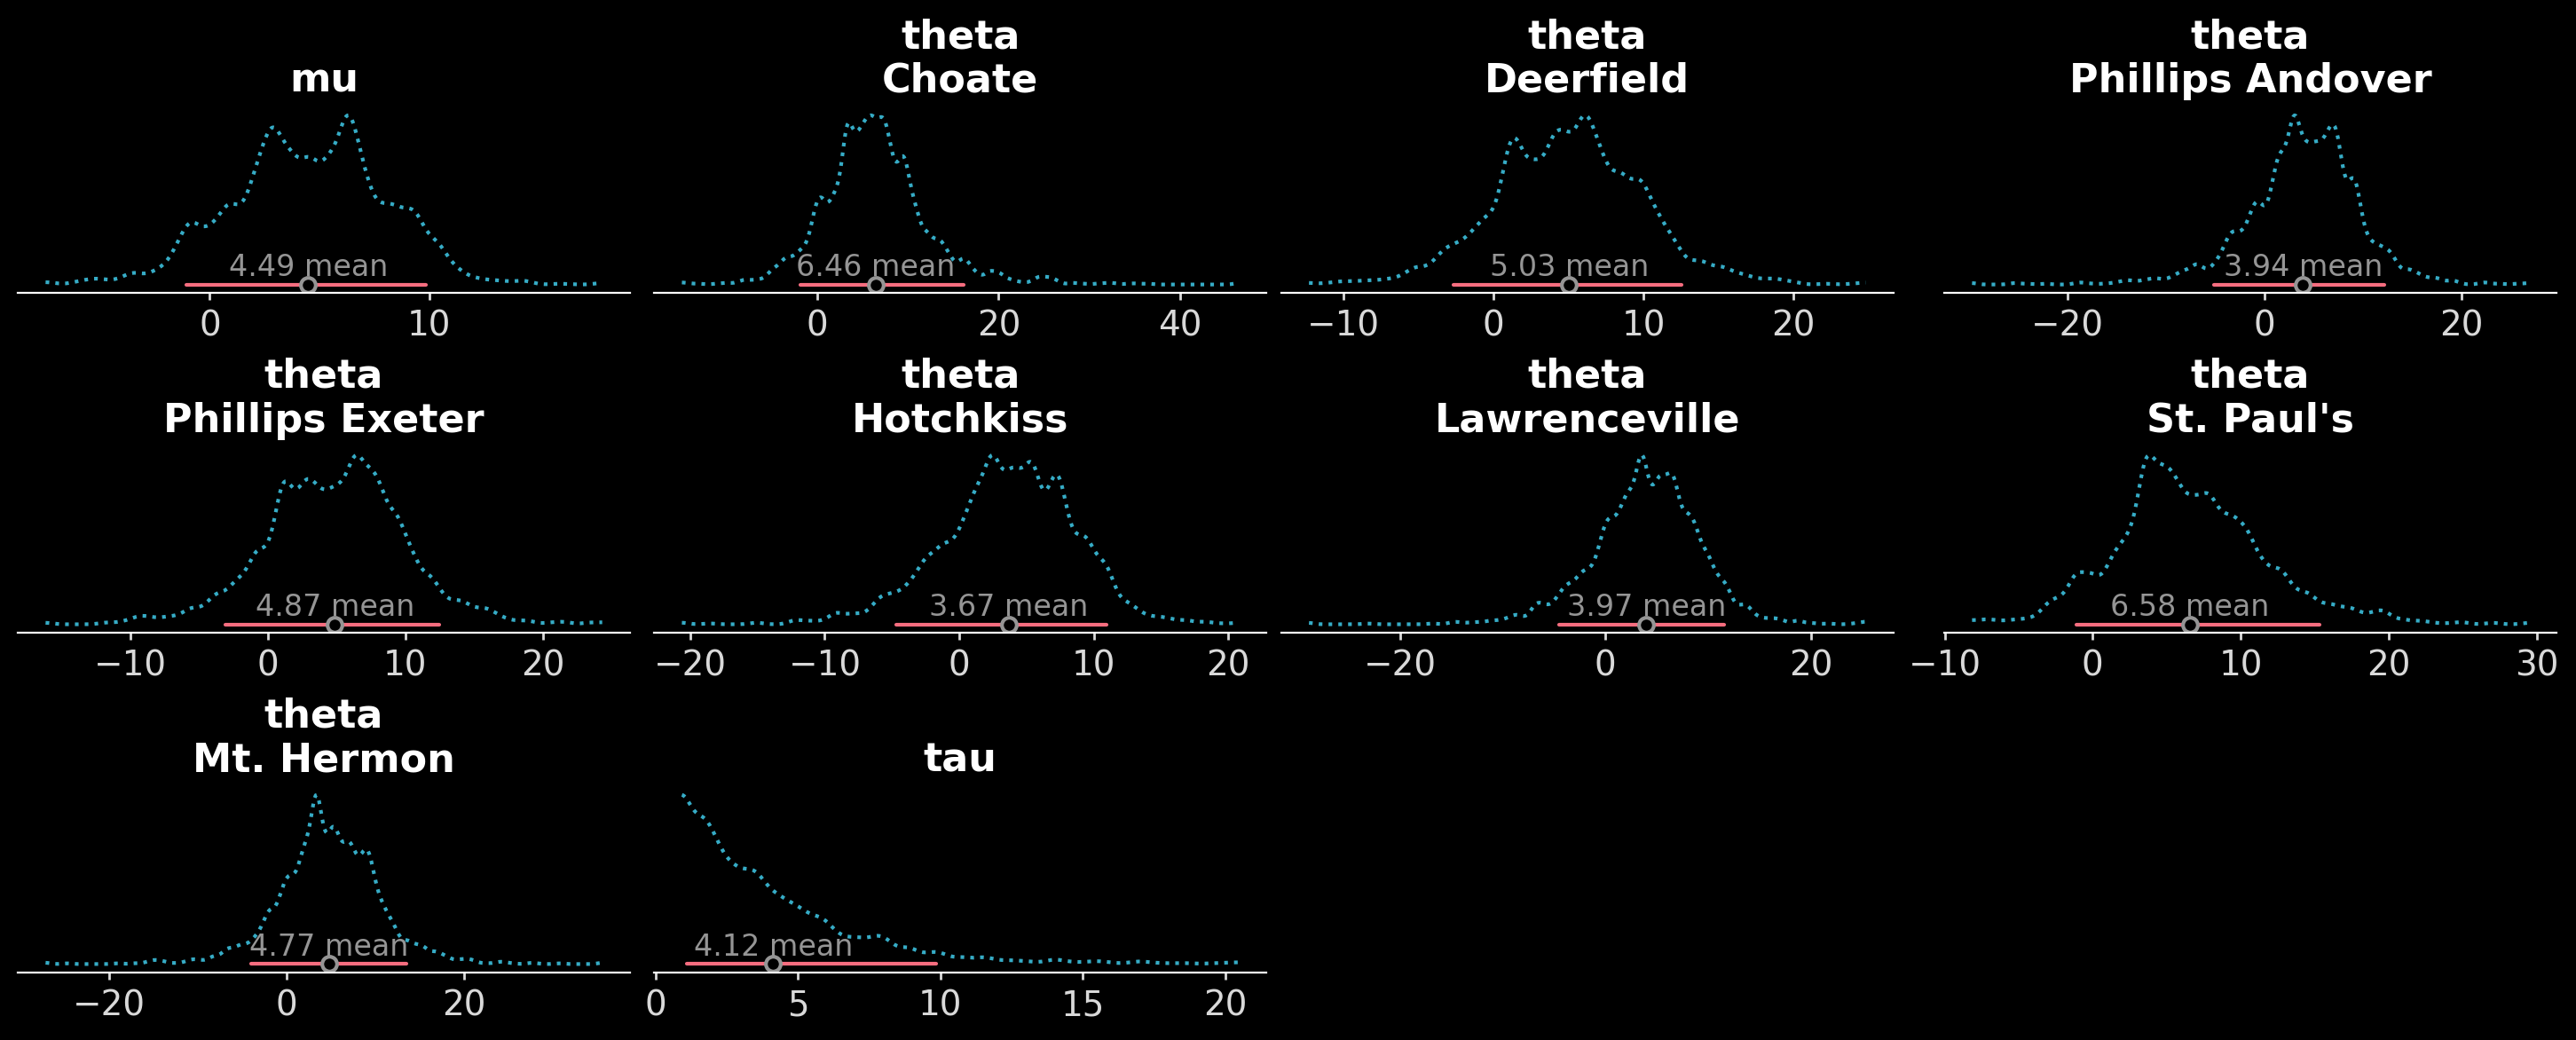

In [30]:
azp.plot_dist(
    data,
    visuals={
        "point_estimate": {"edgecolor": "B2", "facecolor": "B0", "width": 1.5},
        "dist": {"linestyle": "C2"},
        "credible_interval": {"color": "C1"}
    },
);

Now let's try these same arguments in a different theme and backend:

In [31]:
import plotly.io as pio
azp.style.use("arviz-vibrant")

pio.renderers.default = "png"

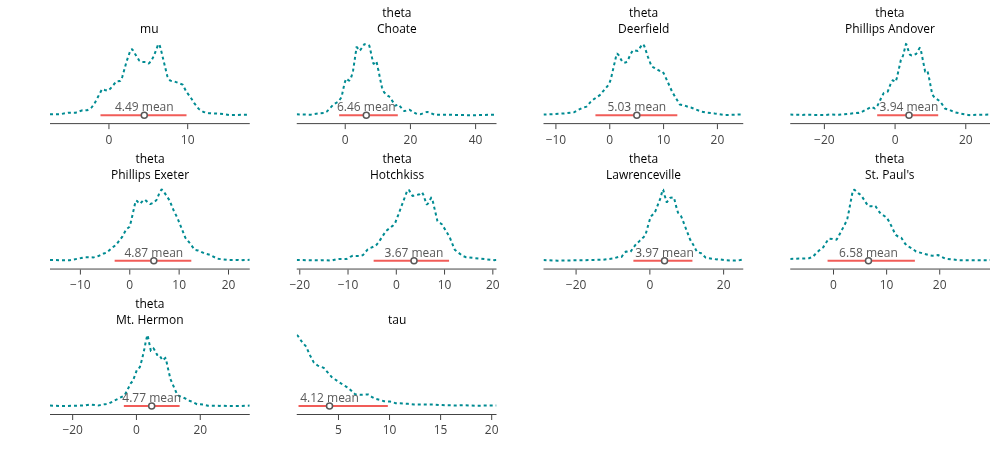

In [32]:
pc = azp.plot_dist(
    data,
    backend="plotly",
    visuals={
        "point_estimate": {"edgecolor": "B2", "facecolor": "B0", "width": 1.5},
        "dist": {"linestyle": "C2"},
        "credible_interval": {"color": "C1"}
    },
)
pc.show()

## Combining plots


Sometimes we want to combine different plots into a single figure. For example, we may want to plot the posterior distribution of the variable `mu` with a KDE and a ECDF in the same figure. We can do that using the `combine_plots` function. This function takes a `DataTree` (or other valid input) and a list of plotting functions.

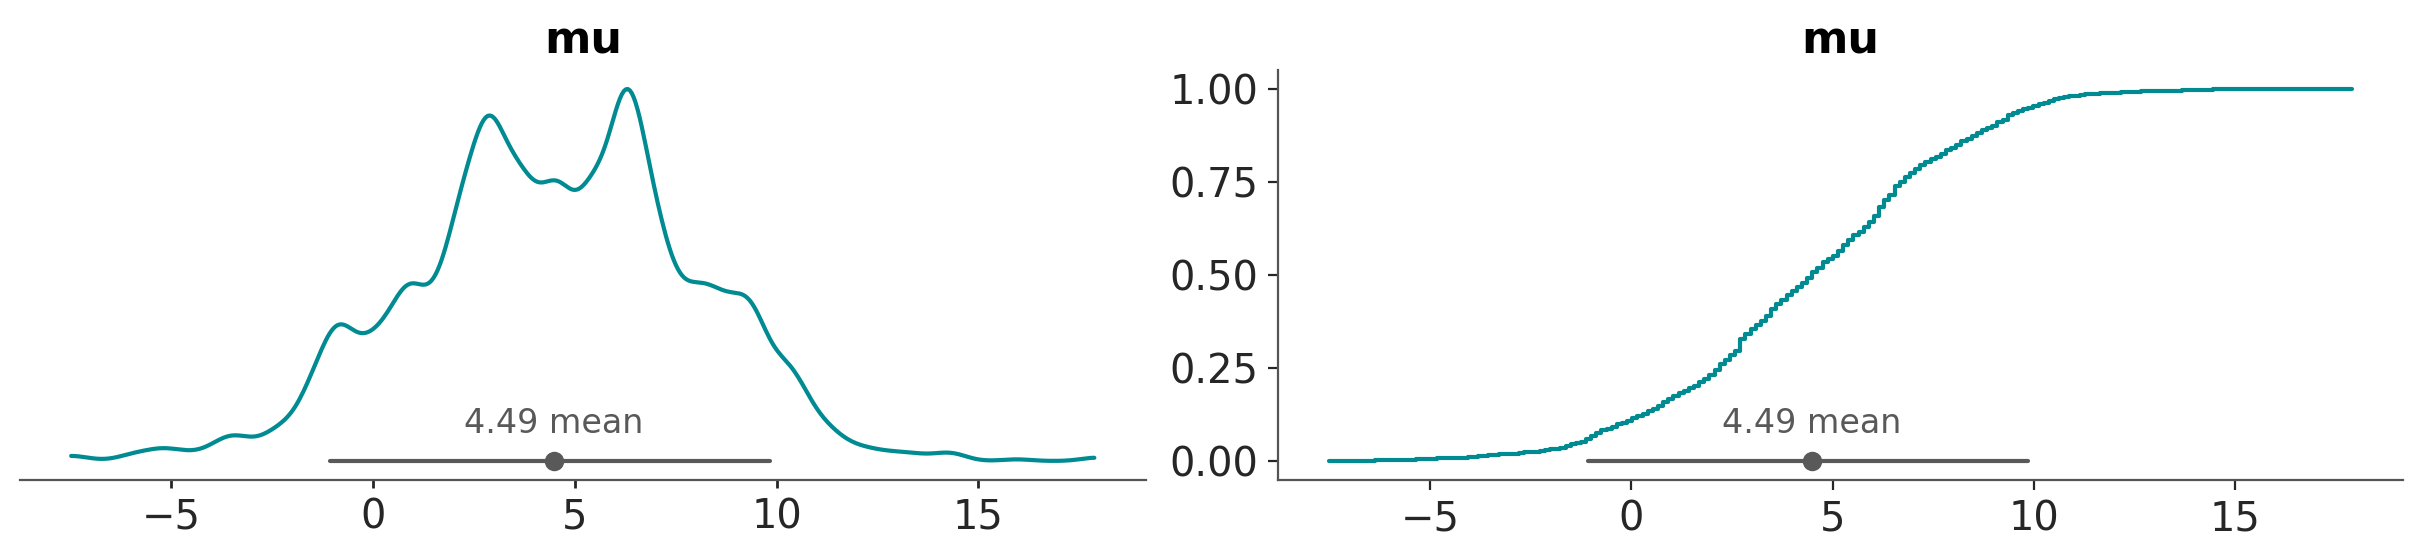

In [33]:
pc = azp.combine_plots(
    data,
    [
        (azp.plot_dist, {"kind": "kde"}),
        (azp.plot_dist, {"kind": "ecdf"}),
    ],
    var_names=["mu"],
)


The list of plots can be of different types, but some restrictions apply, like they should operate on the same group and variable names.

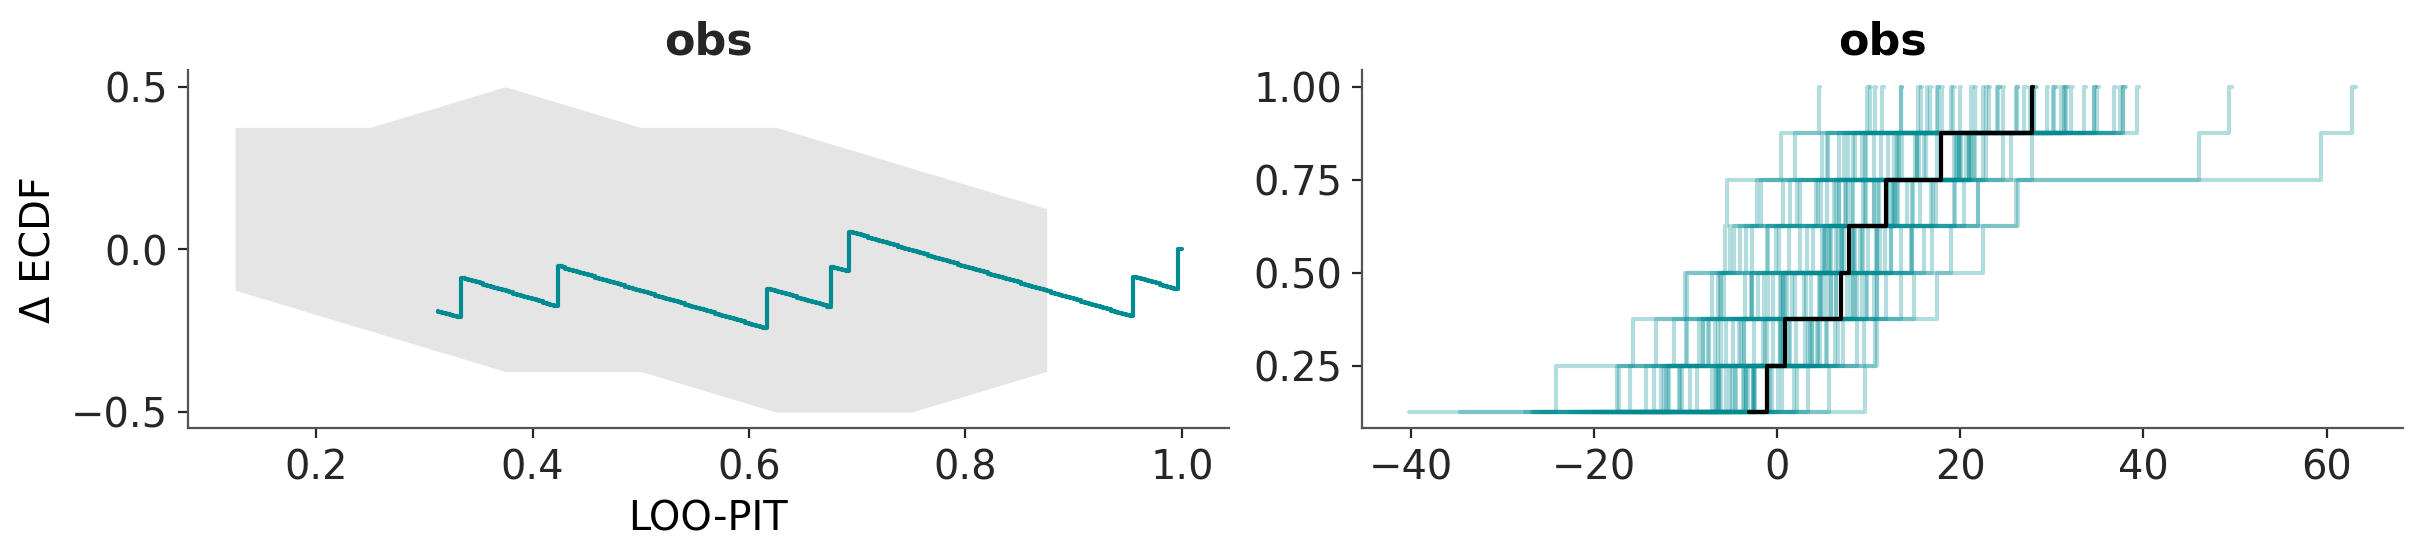

In [34]:
pc = azp.combine_plots(
    data,
    [
        (azp.plot_loo_pit, {}),
        (azp.plot_ppc_dist, {"kind": "ecdf"}),
    ],
    group="posterior_predictive",
)

:::{seealso}
* [arviz-base](https://arviz-base.readthedocs.io/en/latest/) data related functionality, including converters from different PPLs.
* [arviz-stats](https://arviz-stats.readthedocs.io/en/latest/) for statistical summaries, diagnostics, metrics and other estimators.
* [Exploratory Analysis of Bayesian Models](https://arviz-devs.github.io/EABM/) online book. 
* The {ref}`intro to PlotCollection  <use_plotcollection>` tutorial, for more advanced usage of ArviZ plotting functions.
* The {ref}`your custom plot <compose_own_plot>` tutorial, to learn how to create your own custom plots using ArviZ.
:::